In [1]:
import pandas as pd
import os

In [3]:
import pandas as pd
import os

# Define the path to the data folder
data_folder = 'data'

# List of CSV files to load
csv_files = [
    'PUBLIC_ARCHIVE#NETWORK_EQUIPMENTDETAIL#FILE01#202501010000.CSV',
    'PUBLIC_ARCHIVE#NETWORK_OUTAGEDETAIL#FILE01#202501010000.CSV',
    'PUBLIC_ARCHIVE#NETWORK_OUTAGESTATUSCODE#FILE01#202501010000.CSV',
    'PUBLIC_ARCHIVE#NETWORK_SUBSTATIONDETAIL#FILE01#202501010000.CSV'
]

# Create an empty dictionary to store the dataframes
dfs = {}

# Load each CSV file into a pandas DataFrame, skipping the first row and using the second row as headers
for file in csv_files:
    file_path = os.path.join(data_folder, file)
    df_name = file.split('#')[1].replace('DETAIL', '') # Extract a clean name for the dataframe
    try:
        dfs[df_name] = pd.read_csv(file_path, header=1) # Modified: header=1 to use the second row as headers
        print(f"Loaded {file} into DataFrame '{df_name}' with second row as header.")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please ensure it's in the 'data' folder.")
        continue # Skip to the next file if one is not found
    except Exception as e:
        print(f"An error occurred while loading {file}: {e}")
        continue

# Check if dataframes were loaded before proceeding with preprocessing
if 'NETWORK_EQUIPMENT' in dfs and 'NETWORK_SUBSTATION' in dfs:
    equipment_df = dfs['NETWORK_EQUIPMENT']
    outage_df = dfs['NETWORK_OUTAGE']
    outage_status_df = dfs['NETWORK_OUTAGESTATUSCODE']
    substation_df = dfs['NETWORK_SUBSTATION']

Loaded PUBLIC_ARCHIVE#NETWORK_EQUIPMENTDETAIL#FILE01#202501010000.CSV into DataFrame 'NETWORK_EQUIPMENT' with second row as header.
Loaded PUBLIC_ARCHIVE#NETWORK_OUTAGEDETAIL#FILE01#202501010000.CSV into DataFrame 'NETWORK_OUTAGE' with second row as header.
Loaded PUBLIC_ARCHIVE#NETWORK_OUTAGESTATUSCODE#FILE01#202501010000.CSV into DataFrame 'NETWORK_OUTAGESTATUSCODE' with second row as header.
Loaded PUBLIC_ARCHIVE#NETWORK_SUBSTATIONDETAIL#FILE01#202501010000.CSV into DataFrame 'NETWORK_SUBSTATION' with second row as header.


# EQUIPMENT DATA

In [5]:
equipment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29624 entries, 0 to 29623
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I                29624 non-null  object 
 1   NETWORK          29624 non-null  object 
 2   EQUIPMENTDETAIL  29624 non-null  object 
 3   2                29623 non-null  float64
 4   SUBSTATIONID     20995 non-null  object 
 5   EQUIPMENTTYPE    23584 non-null  object 
 6   EQUIPMENTID      21573 non-null  object 
 7   VALIDFROM        29623 non-null  object 
 8   VALIDTO          29623 non-null  object 
 9   VOLTAGE          23612 non-null  object 
 10  DESCRIPTION      25024 non-null  object 
 11  LASTCHANGED      29623 non-null  object 
 12  ELEMENTID        29623 non-null  float64
dtypes: float64(2), object(11)
memory usage: 2.9+ MB


### Get VALIDTO_YEAR and VALIDFROM_YEAR by splicing the dates to get the first 4 digits. splicing because conversion using pd.datetime function results in some NaT due to future dates

In [7]:
# Ensure 'VALIDFROM' and 'VALIDTO' columns exist and are of string type
if 'VALIDFROM' in equipment_df.columns and 'VALIDTO' in equipment_df.columns:
    # Convert these columns to string type first, to ensure .str accessor works reliably
    equipment_df['VALIDFROM'] = equipment_df['VALIDFROM'].astype(str)
    equipment_df['VALIDTO'] = equipment_df['VALIDTO'].astype(str)

    # Create a copy for processing
    equipment_processed_df = equipment_df.copy()

    # --- NEW APPROACH: Extract year by string slicing ---
    # This assumes the year is always the first 4 characters.
    # We use .str.slice(0, 4) to get the first four characters.
    # .str.isnumeric() checks if the result is purely numeric to avoid errors and convert to int.
    # Errors='coerce' will turn non-numeric results (from 'invalid_date_string') into NaN.
    equipment_processed_df['EQ_VALIDFROM_YEAR'] = pd.to_numeric(
        equipment_processed_df['VALIDFROM'].str.slice(0, 4), errors='coerce'
    ).astype('Int32') # Use 'Int32' for integer with NaN support

    equipment_processed_df['EQ_VALIDTO_YEAR'] = pd.to_numeric(
        equipment_processed_df['VALIDTO'].str.slice(0, 4), errors='coerce'
    ).astype('Int32') # Use 'Int32' for integer with NaN support

    # You can still identify the inconsistent ones if you want,
    # by checking if original string could be parsed into a year
    inconsistent_rows_mask_from = equipment_processed_df['EQ_VALIDFROM_YEAR'].isna()
    inconsistent_rows_mask_to = equipment_processed_df['EQ_VALIDTO_YEAR'].isna()
    inconsistent_rows_mask = inconsistent_rows_mask_from | inconsistent_rows_mask_to

    if inconsistent_rows_mask.any():
        print("\n--- Rows with Inconsistent Year Extraction ---")
        print("These rows did not allow year extraction from the first 4 characters:")

        inconsistent_data_display = pd.DataFrame({
            'Original VALIDFROM': equipment_df['VALIDFROM'][inconsistent_rows_mask], # Use original_df here
            'Original VALIDTO': equipment_df['VALIDTO'][inconsistent_rows_mask]
        })
        print(inconsistent_data_display)
        print("You can inspect these values to determine why year extraction failed.")

        equipment_ids_with_nat = equipment_df.loc[inconsistent_rows_mask, 'EQUIPMENTID']
        print(f"\n**EQUIPMENT IDs where year extraction resulted in NaN:**")
        print(equipment_ids_with_nat.tolist())
    else:
        print("\nAll 'VALIDFROM' and 'VALIDTO' values successfully had years extracted from the first 4 characters.")
        equipment_ids_with_nat = pd.Series([])

    # No full datetime conversion, so no 'VALIDFROM' or 'VALIDTO' as NaT in processed_df
    # However, 'VALIDFROM_YEAR' and 'VALIDTO_YEAR' might have NaN if slicing failed.

    print("\n--- equipment_processed_df (with year extracted by string slicing and age) ---")
    #print(equipment_processed_df.head(10))
    print(f"\nShape of equipment_processed_df: {equipment_processed_df.shape}")
    print(f"Count of NaN in 'EQ_VALIDFROM_YEAR': {equipment_processed_df['EQ_VALIDFROM_YEAR'].isna().sum()}")
    print(f"Count of NaN in 'EQ_VALIDTO_YEAR': {equipment_processed_df['EQ_VALIDTO_YEAR'].isna().sum()}")

else:
    print("Skipping Equipment Detail preprocessing: 'VALIDFROM' or 'VALIDTO' columns not found in equipment_df.")


--- Rows with Inconsistent Year Extraction ---
These rows did not allow year extraction from the first 4 characters:
      Original VALIDFROM Original VALIDTO
29623                nan              nan
You can inspect these values to determine why year extraction failed.

**EQUIPMENT IDs where year extraction resulted in NaN:**
[nan]

--- equipment_processed_df (with year extracted by string slicing and age) ---

Shape of equipment_processed_df: (29624, 15)
Count of NaN in 'EQ_VALIDFROM_YEAR': 1
Count of NaN in 'EQ_VALIDTO_YEAR': 1


In [9]:
equipment_processed_df['EQ_VALIDTO_YEAR'].unique()

<IntegerArray>
[9999, 2024, 2015, 2003, 2005, 2009, 2019, 2004, 2007, 2021, 2008, 2013, 2006,
 2016, 2012, 2011, 2020, 2017, 2014, 2023, 2022, 2018, 2010, 2025, 2999, <NA>]
Length: 26, dtype: Int32

In [11]:
equipment_processed_df['EQ_VALIDFROM_YEAR'].unique()

<IntegerArray>
[2003, 2015, 2005, 2019, 2004, 2007, 2021, 2008, 2013, 2016, 2009, 2012, 2011,
 2020, 9999, 2017, 2014, 2006, 2023, 2022, 2018, 2000, 2010, 2999, 1977, 2024,
 1967, 1981, 1991, 2002, 1966, 2025, <NA>]
Length: 33, dtype: Int32

### remove rows where VALIDFROM_YEAR is in the future as it hasnt been employed. convert all future VALIDTO_YEAR to 2024 (cut off) as the equipment is still in operation to date. 

In [13]:
print("\n--- Applying filtering and modification rules to equipment_processed_df ---")

if not equipment_processed_df.empty: # Check if the DataFrame is not empty before processing
    # 1. Drop rows where VALIDFROM_YEAR is greater than 2024
    print("Step 1: Dropping rows where VALIDFROM_YEAR > 2024 (equipment possibly not yet created).")
    initial_length = len(equipment_processed_df)
    equipment_processed_df = equipment_processed_df[equipment_processed_df['EQ_VALIDFROM_YEAR'] <= 2024].copy()
    rows_dropped = initial_length - len(equipment_processed_df)
    print(f"   -> Dropped {rows_dropped} rows.")

    # 2. Identify VALIDTO_YEAR that is more than 2024, and convert them to 2024
    print("Step 2: Converting VALIDTO_YEAR > 2024 to 2024 (equipment still in operation until cut-off).")
    modified_count = (equipment_processed_df['EQ_VALIDTO_YEAR'] > 2024).sum()
    equipment_processed_df['EQ_VALIDTO_YEAR'] = equipment_processed_df['EQ_VALIDTO_YEAR'].apply(lambda x: 2024 if x > 2024 else x)
    print(f"   -> Modified {modified_count} values in 'VALIDTO_YEAR'.")

    print("\n--- equipment_processed_df (after all filtering and modification) ---")
    #print(equipment_processed_df.head()) # Display the first few rows of the modified DataFrame
    print(f"\nFinal shape of equipment_processed_df: {equipment_processed_df.shape}")
else:
    print("\n'equipment_processed_df' is empty. Skipping filtering and modification steps.")



--- Applying filtering and modification rules to equipment_processed_df ---
Step 1: Dropping rows where VALIDFROM_YEAR > 2024 (equipment possibly not yet created).
   -> Dropped 257 rows.
Step 2: Converting VALIDTO_YEAR > 2024 to 2024 (equipment still in operation until cut-off).
   -> Modified 19005 values in 'VALIDTO_YEAR'.

--- equipment_processed_df (after all filtering and modification) ---

Final shape of equipment_processed_df: (29367, 15)


In [15]:
equipment_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29367 entries, 0 to 29620
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   I                  29367 non-null  object 
 1   NETWORK            29367 non-null  object 
 2   EQUIPMENTDETAIL    29367 non-null  object 
 3   2                  29367 non-null  float64
 4   SUBSTATIONID       20789 non-null  object 
 5   EQUIPMENTTYPE      23362 non-null  object 
 6   EQUIPMENTID        21366 non-null  object 
 7   VALIDFROM          29367 non-null  object 
 8   VALIDTO            29367 non-null  object 
 9   VOLTAGE            23595 non-null  object 
 10  DESCRIPTION        25006 non-null  object 
 11  LASTCHANGED        29367 non-null  object 
 12  ELEMENTID          29367 non-null  float64
 13  EQ_VALIDFROM_YEAR  29367 non-null  Int32  
 14  EQ_VALIDTO_YEAR    29367 non-null  int64  
dtypes: Int32(1), float64(2), int64(1), object(11)
memory usage: 3.5+ MB


In [17]:
equipment_processed_df = equipment_processed_df[['SUBSTATIONID', 'EQUIPMENTID', 'VOLTAGE', 'EQUIPMENTTYPE','EQ_VALIDFROM_YEAR','EQ_VALIDTO_YEAR']]

# substation data

In [19]:
substation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   I                 1065 non-null   object 
 1   NETWORK           1065 non-null   object 
 2   SUBSTATIONDETAIL  1065 non-null   object 
 3   2                 1064 non-null   float64
 4   SUBSTATIONID      1064 non-null   object 
 5   VALIDFROM         1064 non-null   object 
 6   VALIDTO           1064 non-null   object 
 7   DESCRIPTION       927 non-null    object 
 8   REGIONID          927 non-null    object 
 9   OWNERID           927 non-null    object 
 10  LASTCHANGED       1064 non-null   object 
dtypes: float64(1), object(10)
memory usage: 91.7+ KB


### filter region = QLD to align with project scope

In [21]:
import re

In [23]:
# Filter the Substation Detail dataset to extract only those where 'REGION' contains 'QLD'
# Using case=False for case-insensitive matching, and na=False to treat NaN as False (not containing 'QLD')
substation_qld_region_df = substation_df[substation_df['REGIONID'].str.contains('QLD', case=False, na=False)].copy()


In [25]:
        # Define a more robust regex pattern
        # This pattern tries to capture the last numerical value followed by 'kV' or 'V' (case-insensitive)
        # If no such voltage is found, it will capture the entire string as suburb.
        # Group 1: Suburb (everything before the potential voltage part)
        # Group 2: Voltage (optional, numbers with 'kV' or 'V', and 'Ps' as seen in example)
        # We need to consider "Mount Stuart Ps" which does not fit voltage pattern.
        # Let's try to capture anything that looks like a number followed by kV, V, or kA, or even just 'Ps'.
        # If the end is not a voltage, it's all suburb.

        # Regex to capture potential voltage at the end (e.g., 132kV, 275kV, 11V, 33kV, or Ps)
        # (?:(\d+\s*[kM]?V)\b|(\bPs\b)) - non-capturing group for the whole optional voltage part
        # \s* - optional space before the voltage
        # (\d+\s*[kM]?V) - captures "132kV", "275kV", "11V", "33 kV" etc.
        # \bPs\b - captures "Ps" word boundary for "Mount Stuart Ps"
        # The (?:...) means it's a non-capturing group.

        # Let's simplify the regex for now based on the examples and make the voltage part optional.
        # This regex tries to split at the LAST occurrence of a number followed by 'kV' or 'V' (case-insensitive).
        # If it doesn't find such a pattern at the end, the suburb will be the whole string and voltage will be NaN.
pattern = r"^(.*?)\s*(\d+\.?\d*\s*[kM]?V|Ps)?$"

        # This pattern says:
        # ^(.*?) : Capture everything from the start (non-greedy) as Suburb
        # \s* : followed by optional spaces
        # (     : Start of optional voltage group
        #   \d+ : one or more digits
        #   \.? : optional decimal point
        #   \d* : zero or more digits
        #   \s* : optional spaces
        #   [kM]?V : 'kV', 'MV', or 'V' (optional 'k' or 'M')
        #   |Ps   : OR literally 'Ps'
        # )?    : End of optional voltage group, making the whole voltage part optional
        # $     : End of the string

        # Apply the regex to extract Suburb and Voltage into temporary columns
        # `expand=True` creates new columns for each captured group
extracted_data = substation_qld_region_df['DESCRIPTION'].str.extract(pattern, flags=re.IGNORECASE)

        # Assign the extracted data to new columns
        # extracted_data[0] will be the suburb
        # extracted_data[1] will be the voltage string (e.g., "132kV", "275kV", "Ps", or NaN if no match)
substation_qld_region_df['SUBSTATION_SUBURB'] = extracted_data[0].str.strip()
substation_qld_region_df['SUBSTATION_VOLTAGE'] = extracted_data[1].str.strip() # Strip whitespace from voltage

        # For rows where voltage extraction might result in NaN, or is 'Ps',
        # we might want to clean up the suburb to not include "Ps" if it was part of the suburb
        # and no voltage was extracted. This needs careful handling.
        # For simplicity, if SUBSTATION_VOLTAGE is NaN, the whole string was put into suburb.

        # Let's adjust the suburb for cases where voltage extraction failed,
        # but the string ends with a voltage-like pattern that wasn't captured,
        # or where the voltage part was implicitly absorbed into the suburb.

        # More robust extraction: split from the end if voltage pattern is found
        def split_description(description):
            if pd.isna(description):
                return None, None
            desc = str(description).strip()
            # Regex to find voltage patterns at the end: numbers followed by kV, V, A, or 'Ps'
            # (e.g., 132kV, 275kV, 11V, 33kA, Ps)
            voltage_match = re.search(r'(\s+\d+\.?\d*\s*[kM]?[VAD]?\b|\s+Ps\b)$', desc, re.IGNORECASE)

            if voltage_match:
                voltage_part = voltage_match.group(1).strip()
                suburb_part = desc[:voltage_match.start(1)].strip()
                return suburb_part, voltage_part
            else:
                # If no voltage pattern found, the whole string is the suburb
                return desc, None

        # Apply this custom splitting function
substation_qld_region_df[['SUBSTATION_SUBURB', 'SUBSTATION_VOLTAGE']] = substation_qld_region_df['DESCRIPTION'].apply(lambda x: pd.Series(split_description(x)))

In [27]:
# Ensure 'VALIDFROM' and 'VALIDTO' columns exist and are of string type
if 'VALIDFROM' in substation_qld_region_df.columns and 'VALIDTO' in substation_qld_region_df.columns:
    # Convert these columns to string type first, to ensure .str accessor works reliably
    substation_qld_region_df['VALIDFROM'] = substation_qld_region_df['VALIDFROM'].astype(str)
    substation_qld_region_df['VALIDTO'] = substation_qld_region_df['VALIDTO'].astype(str)

    # Create a copy for processing
    substation_processed_df = substation_qld_region_df.copy()

    # --- NEW APPROACH: Extract year by string slicing ---
    # This assumes the year is always the first 4 characters.
    # We use .str.slice(0, 4) to get the first four characters.
    # .str.isnumeric() checks if the result is purely numeric to avoid errors and convert to int.
    # Errors='coerce' will turn non-numeric results (from 'invalid_date_string') into NaN.
    substation_processed_df['VALIDFROM_YEAR'] = pd.to_numeric(
        substation_processed_df['VALIDFROM'].str.slice(0, 4), errors='coerce'
    ).astype('Int32') # Use 'Int32' for integer with NaN support

    substation_processed_df['VALIDTO_YEAR'] = pd.to_numeric(
        substation_processed_df['VALIDTO'].str.slice(0, 4), errors='coerce'
    ).astype('Int32') # Use 'Int32' for integer with NaN support

    print("\n--- substation_processed_df (with year extracted by string slicing and age) ---")
    #print(substation_processed_df.head(10))
    print(f"\nShape of substation_processed_df: {substation_processed_df.shape}")
    print(f"Count of NaN in 'VALIDFROM_YEAR': {substation_processed_df['VALIDFROM_YEAR'].isna().sum()}")
    print(f"Count of NaN in 'VALIDTO_YEAR': {substation_processed_df['VALIDTO_YEAR'].isna().sum()}")

else:
    print("Skipping Substation Detail preprocessing: 'VALIDFROM' or 'VALIDTO' columns not found in substation_df.")


--- substation_processed_df (with year extracted by string slicing and age) ---

Shape of substation_processed_df: (301, 15)
Count of NaN in 'VALIDFROM_YEAR': 0
Count of NaN in 'VALIDTO_YEAR': 0


In [29]:
substation_processed_df['VALIDTO_YEAR'].unique()

<IntegerArray>
[9999, 2016, 2006, 2018, 2015, 2008, 2014, 2009, 2022]
Length: 9, dtype: Int32

In [31]:
substation_processed_df['VALIDFROM_YEAR'].unique()

<IntegerArray>
[2003, 2006, 2020, 2004, 2005, 2007, 2008, 2014, 2009, 2010, 2012, 2013, 2021,
 2022, 2016, 2015, 2019, 2023, 2024]
Length: 19, dtype: Int32

In [33]:
print("\n--- Applying filtering and modification rules to substation_processed_df ---")

if not equipment_processed_df.empty: # Check if the DataFrame is not empty before processing
    # 1. Drop rows where VALIDFROM_YEAR is greater than 2024
    print("Step 1: Dropping rows where VALIDFROM_YEAR > 2024 (station possibly not yet created).")
    initial_length = len(substation_processed_df)
    substation_processed_df = substation_processed_df[substation_processed_df['VALIDFROM_YEAR'] <= 2024].copy()
    rows_dropped = initial_length - len(substation_processed_df)
    print(f"   -> Dropped {rows_dropped} rows.")

    # 2. Identify VALIDTO_YEAR that is more than 2024, and convert them to 2024
    print("Step 2: Converting VALIDTO_YEAR > 2024 to 2024 (station still in operation until cut-off).")
    modified_count = (substation_processed_df['VALIDTO_YEAR'] > 2024).sum()
    substation_processed_df['VALIDTO_YEAR'] = substation_processed_df['VALIDTO_YEAR'].apply(lambda x: 2024 if x > 2024 else x)
    print(f"   -> Modified {modified_count} values in 'VALIDTO_YEAR'.")

    print("\n--- substation_processed_df (after all filtering and modification) ---")
    #print(equipment_processed_df.head()) # Display the first few rows of the modified DataFrame
    print(f"\nFinal shape of substation_processed_df: {substation_processed_df.shape}")
else:
    print("\n'substation_processed_df' is empty. Skipping filtering and modification steps.")



--- Applying filtering and modification rules to substation_processed_df ---
Step 1: Dropping rows where VALIDFROM_YEAR > 2024 (station possibly not yet created).
   -> Dropped 0 rows.
Step 2: Converting VALIDTO_YEAR > 2024 to 2024 (station still in operation until cut-off).
   -> Modified 234 values in 'VALIDTO_YEAR'.

--- substation_processed_df (after all filtering and modification) ---

Final shape of substation_processed_df: (301, 15)


In [35]:
substation_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 1063
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   I                   301 non-null    object 
 1   NETWORK             301 non-null    object 
 2   SUBSTATIONDETAIL    301 non-null    object 
 3   2                   301 non-null    float64
 4   SUBSTATIONID        301 non-null    object 
 5   VALIDFROM           301 non-null    object 
 6   VALIDTO             301 non-null    object 
 7   DESCRIPTION         301 non-null    object 
 8   REGIONID            301 non-null    object 
 9   OWNERID             301 non-null    object 
 10  LASTCHANGED         301 non-null    object 
 11  SUBSTATION_SUBURB   301 non-null    object 
 12  SUBSTATION_VOLTAGE  198 non-null    object 
 13  VALIDFROM_YEAR      301 non-null    Int32  
 14  VALIDTO_YEAR        301 non-null    int64  
dtypes: Int32(1), float64(1), int64(1), object(12)
memory usage: 3

In [37]:
substation_processed_df = substation_processed_df[['SUBSTATIONID', 'SUBSTATION_SUBURB']]

# filter equipment data with using the substation id from the filtered qld substation data

In [39]:
print("\nSUBSTATIONIDs in substation_processed_df:")
print(substation_processed_df['SUBSTATIONID'].nunique())

# --- NEW CODE: Filter equipment_processed_df based on substation_processed_df IDs ---

# Get a list of unique SUBSTATIONIDs from substation_processed_df
valid_substation_ids = substation_processed_df['SUBSTATIONID'].unique()

# Filter equipment_processed_df to keep only rows where SUBSTATIONID is in valid_substation_ids
filtered_equipment_df = equipment_processed_df[
    equipment_processed_df['SUBSTATIONID'].isin(valid_substation_ids)
].copy()

print(f"\nFiltered equipment_processed_df (only SUBSTATIONIDs present in substation_processed_df):")

print(f"Original shape: {equipment_processed_df.shape}, Filtered shape: {filtered_equipment_df.shape}")


SUBSTATIONIDs in substation_processed_df:
283

Filtered equipment_processed_df (only SUBSTATIONIDs present in substation_processed_df):
Original shape: (29367, 6), Filtered shape: (7356, 6)


In [41]:
# Assuming filtered_equipment_df is your DataFrame

# Drop rows where 'VOLTAGE' is NaN
filtered_equipment_df = filtered_equipment_df.dropna(subset=['VOLTAGE']).copy()
filtered_equipment_df = filtered_equipment_df.dropna(subset=['EQUIPMENTID']).copy()


## identify duplicated substain id + equipment id combinations, then add equipment version

In [45]:


print("\n--- Checking for duplicate (SUBSTATIONID, EQUIPMENTID) combinations ---")

# Identify duplicate rows based on the specified subset of columns
# 'keep=False' marks all occurrences of a duplicate combination as True
duplicate_combinations_mask = filtered_equipment_df.duplicated(
    subset=['SUBSTATIONID', 'EQUIPMENTID'],
    keep=False # Set to False to mark all duplicates (including the first occurrence)
)

# Filter the DataFrame to show only the rows that are duplicates based on the combination
duplicate_equipment_substation_rows = filtered_equipment_df[duplicate_combinations_mask].copy()

if not duplicate_equipment_substation_rows.empty:
    print(f"Found {len(duplicate_equipment_substation_rows)} rows with duplicate (SUBSTATIONID, EQUIPMENTID) combinations.")
    print("Here are the first 10 rows of these duplicate combinations:")
    # Sort by the combination to see duplicates grouped together for easier inspection
    print(duplicate_equipment_substation_rows.sort_values(by=['SUBSTATIONID', 'EQUIPMENTID']).head(10))
else:
    print("No duplicate (SUBSTATIONID, EQUIPMENTID) combinations found in combined_equipment_substation_df_2.")


--- Checking for duplicate (SUBSTATIONID, EQUIPMENTID) combinations ---
Found 1410 rows with duplicate (SUBSTATIONID, EQUIPMENTID) combinations.
Here are the first 10 rows of these duplicate combinations:
      SUBSTATIONID   EQUIPMENTID VOLTAGE EQUIPMENTTYPE  EQ_VALIDFROM_YEAR  \
18010     CAL_B_PS          7159     132          LINE               2018   
29419     CAL_B_PS          7159     132          LINE               2019   
23320     CHARTWRS           3B1      66           BUS               2022   
23321     CHARTWRS           3B1      66           BUS               2022   
25876     CHARTWRS           3B2      66           BUS               2022   
25877     CHARTWRS           3B2      66           BUS               2022   
22018     CPR_EAST          3MN1      33           BUS               2022   
25861     CPR_EAST          3MN1      66           BUS               2022   
39        CRAIGLIE  132KV_7200/2     132          LINE               2003   
29042     CRAIGLIE  132K

In [52]:
# --- Step 1: Sort the DataFrame to ensure consistent versioning ---
# Sort by SUBSTATIONID, EQUIPMENTID, and then EQ_VALIDFROM_YEAR chronologically.
df_sorted = filtered_equipment_df.sort_values(
    by=['SUBSTATIONID', 'EQUIPMENTID', 'EQ_VALIDFROM_YEAR']
).copy()

print("\n--- Step 2: Add an EQUIPMENT_VERSION_ID ---")
# Use cumcount() to assign a sequential number within each group
# This will be 0 for the first record, 1 for the second, etc.
df_sorted['EQUIPMENT_VERSION_ID'] = df_sorted.groupby(['SUBSTATIONID', 'EQUIPMENTID']).cumcount()

# The new DataFrame is now called 'equipment_versioned_df'
equipment_versioned_df = df_sorted.copy()

print("\nDataFrame with 'EQUIPMENT_VERSION_ID' (showing versions for problematic combos):")
print(equipment_versioned_df[['SUBSTATIONID', 'EQUIPMENTID', 'EQ_VALIDFROM_YEAR', 'EQ_VALIDTO_YEAR', 'VOLTAGE', 'EQUIPMENT_VERSION_ID']].head(20))

# --- Verification: Check if the new composite key is unique ---
composite_key_duplicates = equipment_versioned_df.duplicated(
    subset=['SUBSTATIONID', 'EQUIPMENTID', 'EQUIPMENT_VERSION_ID'], keep=False
)
if composite_key_duplicates.any():
    print("\nWARNING: Still found duplicates on (SUBSTATIONID, EQUIPMENTID, EQUIPMENT_VERSION_ID)!")
    print(equipment_versioned_df[composite_key_duplicates])
    print("This indicates a data quality issue where multiple records for the exact same version/period exist.")
else:
    print("\nSuccess: (SUBSTATIONID, EQUIPMENTID, EQUIPMENT_VERSION_ID) is now a unique composite key.")



--- Step 2: Add an EQUIPMENT_VERSION_ID ---

DataFrame with 'EQUIPMENT_VERSION_ID' (showing versions for problematic combos):
      SUBSTATIONID   EQUIPMENTID  EQ_VALIDFROM_YEAR  EQ_VALIDTO_YEAR VOLTAGE  \
2351       BCDE_PS  132KV_GT_GEN               2003             2024     132   
6968       BCDE_PS      GEN_1212               2003             2024      11   
3724       BCDE_PS            X1               2003             2024  132_11   
12197     BNGALORA          9901               2006             2024     110   
12864     BNGALORA           9B1               2006             2024     110   
12866     BNGALORA           9K3               2006             2024     110   
13285     BNGALORA           9K4               2006             2024     110   
9330      BNGALORA           9K5               2006             2024     110   
9775      BNGALORA           DC1               2004             2024      80   
13583     BNGALORA           DC2               2004             2024     

In [54]:
equipment_versioned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5674 entries, 2351 to 22363
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBSTATIONID          5674 non-null   object
 1   EQUIPMENTID           5674 non-null   object
 2   VOLTAGE               5674 non-null   object
 3   EQUIPMENTTYPE         5674 non-null   object
 4   EQ_VALIDFROM_YEAR     5674 non-null   Int32 
 5   EQ_VALIDTO_YEAR       5674 non-null   int64 
 6   EQUIPMENT_VERSION_ID  5674 non-null   int64 
dtypes: Int32(1), int64(2), object(4)
memory usage: 338.0+ KB


## combine the preprocessed substation data with the processed equipment data where the substation id matches

In [57]:
combined_equipment_substation_df = pd.merge(substation_processed_df, equipment_versioned_df, on='SUBSTATIONID', how='inner')

# outage data

### get completed outages in qld only

In [59]:
outage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802913 entries, 0 to 802912
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   I                 802913 non-null  object 
 1   NETWORK           802913 non-null  object 
 2   OUTAGEDETAIL      802913 non-null  object 
 3   4                 802912 non-null  float64
 4   OUTAGEID          802912 non-null  float64
 5   SUBSTATIONID      708841 non-null  object 
 6   EQUIPMENTTYPE     757948 non-null  object 
 7   EQUIPMENTID       716434 non-null  object 
 8   STARTTIME         802912 non-null  object 
 9   ENDTIME           802912 non-null  object 
 10  SUBMITTEDDATE     802912 non-null  object 
 11  OUTAGESTATUSCODE  802912 non-null  object 
 12  RESUBMITREASON    217654 non-null  object 
 13  RESUBMITOUTAGEID  217676 non-null  float64
 14  RECALLTIMEDAY     802912 non-null  float64
 15  RECALLTIMENIGHT   802912 non-null  float64
 16  LASTCHANGED       80

In [61]:
# Filter equipment_processed_df to keep only rows where SUBSTATIONID is in valid_substation_ids
filtered_outage_df = outage_df[outage_df['SUBSTATIONID'].isin(valid_substation_ids)].copy()

print(f"\nFiltered filtered_outage_df (only SUBSTATIONIDs present in substation_processed_df):")

print(f"Original shape: {filtered_outage_df.shape}, Filtered shape: {filtered_outage_df.shape}")


Filtered filtered_outage_df (only SUBSTATIONIDs present in substation_processed_df):
Original shape: (253206, 23), Filtered shape: (253206, 23)


In [63]:
outage_df_completed = filtered_outage_df[filtered_outage_df['OUTAGESTATUSCODE'] == 'COMPLETE'].copy()

In [66]:
columns_to_keep = [
    'OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'EQUIPMENTID',
    'RECALLTIMEDAY', 'RECALLTIMENIGHT', 'REASON', 'ISSECONDARY',
    'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME', 'COMPANYREFCODE'
]

outage_df_completed = outage_df_completed[columns_to_keep].copy()

In [68]:
outage_df_cleaned = outage_df_completed.dropna(
    subset=['SUBSTATIONID', 'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME']
).copy()

In [70]:
outage_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103182 entries, 59 to 802910
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   OUTAGEID          103182 non-null  float64
 1   SUBSTATIONID      103182 non-null  object 
 2   EQUIPMENTTYPE     103182 non-null  object 
 3   EQUIPMENTID       102813 non-null  object 
 4   RECALLTIMEDAY     103182 non-null  float64
 5   RECALLTIMENIGHT   103182 non-null  float64
 6   REASON            103182 non-null  object 
 7   ISSECONDARY       103182 non-null  float64
 8   ACTUAL_STARTTIME  103182 non-null  object 
 9   ACTUAL_ENDTIME    103182 non-null  object 
 10  COMPANYREFCODE    102322 non-null  object 
dtypes: float64(4), object(7)
memory usage: 9.4+ MB


### get outage duration

In [73]:
# Ensure 'ACTUAL_STARTTIME' and 'ACTUAL_ENDTIME' columns exist before processing
if 'ACTUAL_STARTTIME' in outage_df_cleaned.columns and 'ACTUAL_ENDTIME' in outage_df_cleaned.columns:
    # Create a temporary copy of the original date columns for comparison
    original_start = outage_df_cleaned['ACTUAL_STARTTIME'].copy()
    original_end = outage_df_cleaned['ACTUAL_ENDTIME'].copy()

    # Create a new DataFrame for converted dates and other relevant columns
    # We'll include OUTAGEID to link back to the original rows
    processed_df = outage_df_cleaned.copy()

    # Convert 'ACTUAL_STARTTIME' and 'ACTUAL_ENDTIME' in the new DataFrame with errors='coerce'
    # Format used: %Y/%m/%d %H:%M:%S
    processed_df['ACTUAL_STARTTIME'] = pd.to_datetime(processed_df['ACTUAL_STARTTIME'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
    processed_df['ACTUAL_ENDTIME'] = pd.to_datetime(processed_df['ACTUAL_ENDTIME'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

    # --- NEW CODE: Calculate Duration in Minutes ---
    print("\n--- Calculating Outage Duration in Minutes ---")

    # Calculate the timedelta
    # This will result in NaT if either ACTUAL_STARTTIME or ACTUAL_ENDTIME is NaT
    processed_df['DURATION_TIMEDELTA'] = processed_df['ACTUAL_ENDTIME'] - processed_df['ACTUAL_STARTTIME']

    # Convert timedelta to total seconds, then to minutes
    # .dt.total_seconds() returns float; dividing by 60 gives minutes.
    # This will result in NaN for rows where DURATION_TIMEDELTA is NaT.
    processed_df['OUTAGE_DURATION_MINUTES'] = processed_df['DURATION_TIMEDELTA'].dt.total_seconds() / 60

    print("Processed DataFrame with 'DURATION_TIMEDELTA' and 'OUTAGE_DURATION_MINUTES':")
    print(processed_df.head())
    print(f"\nNumber of NaT/NaN values in OUTAGE_DURATION_MINUTES: {processed_df['OUTAGE_DURATION_MINUTES'].isna().sum()}")

else:
    print("Skipping duration calculation: 'ACTUAL_STARTTIME' or 'ACTUAL_ENDTIME' columns not found in combined_outage_df_cleaned.")



--- Calculating Outage Duration in Minutes ---
Processed DataFrame with 'DURATION_TIMEDELTA' and 'OUTAGE_DURATION_MINUTES':
    OUTAGEID SUBSTATIONID EQUIPMENTTYPE EQUIPMENTID  RECALLTIMEDAY  \
59    2113.0     H15_LILY           BUS           2          120.0   
60    2114.0     T71_CLMT          LINE  132KV_7153           30.0   
61    2114.0     H15_LILY          LINE  132KV_7153           30.0   
66    5194.0     T50_INFL          LINE        7136           60.0   
67    5194.0     KAR_H_PS          LINE        7136           60.0   

    RECALLTIMENIGHT                 REASON  ISSECONDARY    ACTUAL_STARTTIME  \
59              0.0  HV equipt maintenance          0.0 2003-05-08 05:57:00   
60              0.0  HV equipt maintenance          0.0 2003-05-08 06:25:00   
61              0.0  HV equipt maintenance          0.0 2003-05-08 06:25:00   
66             60.0  HV equipt maintenance          0.0 2003-05-17 07:07:00   
67             60.0  HV equipt maintenance          0.0 200

In [75]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103182 entries, 59 to 802910
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   OUTAGEID                 103182 non-null  float64        
 1   SUBSTATIONID             103182 non-null  object         
 2   EQUIPMENTTYPE            103182 non-null  object         
 3   EQUIPMENTID              102813 non-null  object         
 4   RECALLTIMEDAY            103182 non-null  float64        
 5   RECALLTIMENIGHT          103182 non-null  float64        
 6   REASON                   103182 non-null  object         
 7   ISSECONDARY              103182 non-null  float64        
 8   ACTUAL_STARTTIME         103182 non-null  datetime64[ns] 
 9   ACTUAL_ENDTIME           103182 non-null  datetime64[ns] 
 10  COMPANYREFCODE           102322 non-null  object         
 11  DURATION_TIMEDELTA       103182 non-null  timedelta64[ns]
 12  OUTAGE

In [78]:
combined_equipment_substation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6091 entries, 0 to 6090
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SUBSTATIONID          6091 non-null   object
 1   SUBSTATION_SUBURB     6091 non-null   object
 2   EQUIPMENTID           6091 non-null   object
 3   VOLTAGE               6091 non-null   object
 4   EQUIPMENTTYPE         6091 non-null   object
 5   EQ_VALIDFROM_YEAR     6091 non-null   Int32 
 6   EQ_VALIDTO_YEAR       6091 non-null   int64 
 7   EQUIPMENT_VERSION_ID  6091 non-null   int64 
dtypes: Int32(1), int64(2), object(5)
memory usage: 363.0+ KB


### merged outage data with the combined equipment+substation data and get equipment age at outage

In [80]:
import pandas as pd

# Convert year columns to datetime if needed
combined_equipment_substation_df['EQ_VALIDFROM_YEAR'] = pd.to_datetime(combined_equipment_substation_df['EQ_VALIDFROM_YEAR'], format='%Y')
combined_equipment_substation_df['EQ_VALIDTO_YEAR'] = pd.to_datetime(combined_equipment_substation_df['EQ_VALIDTO_YEAR'], format='%Y')

# Step 1: Merge based on substation_id and equipment_id (cartesian merge, will filter next)
merged_processed_df = pd.merge(processed_df, combined_equipment_substation_df, on=['SUBSTATIONID', 'EQUIPMENTID'], how='left')

# Step 2: Filter where outage occurred during the valid life of equipment
merged_processed_df = merged_processed_df[
    (merged_processed_df['ACTUAL_STARTTIME'] >= merged_processed_df['EQ_VALIDFROM_YEAR']) &
    (merged_processed_df['ACTUAL_STARTTIME'] <= merged_processed_df['EQ_VALIDTO_YEAR'])
]


In [82]:
# Step 3: Calculate age at the time of outage
merged_processed_df['EQ_AGE_AT_OUTAGE'] = merged_processed_df['ACTUAL_STARTTIME'].dt.year - merged_processed_df['EQ_VALIDFROM_YEAR'].dt.year

In [85]:
merged_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109548 entries, 0 to 135568
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   OUTAGEID                 109548 non-null  float64        
 1   SUBSTATIONID             109548 non-null  object         
 2   EQUIPMENTTYPE_x          109548 non-null  object         
 3   EQUIPMENTID              109548 non-null  object         
 4   RECALLTIMEDAY            109548 non-null  float64        
 5   RECALLTIMENIGHT          109548 non-null  float64        
 6   REASON                   109548 non-null  object         
 7   ISSECONDARY              109548 non-null  float64        
 8   ACTUAL_STARTTIME         109548 non-null  datetime64[ns] 
 9   ACTUAL_ENDTIME           109548 non-null  datetime64[ns] 
 10  COMPANYREFCODE           108703 non-null  object         
 11  DURATION_TIMEDELTA       109548 non-null  timedelta64[ns]
 12  OUTAGE_

In [89]:
merged_processed_df['EQUIPMENTTYPE_x'].unique()

array(['BUS', 'LINE', 'CB', 'TRANS', 'SVC', 'CAP', 'REAC', 'ISOL', 'UNIT',
       'REACT'], dtype=object)

In [91]:
merged_processed_df['EQUIPMENTTYPE_y'].unique()

array(['BUS', 'LINE', 'CB', 'TRANS', 'SVC', 'CAP', 'REAC', 'ISOL', 'UNIT',
       'REACT'], dtype=object)

From aemo The type of equipment. Valid values are:
LINE = Line
TRANS = Transformer
CB = Circuit breaker
ISOL = Isolator
CAP = Capacitor
REAC = Reactor
UNIT = Unit


### filter to only include valid equipment type based from aemo website

In [96]:
# Define the list of valid equipment types (converted to uppercase for robust comparison)
valid_equipment_types = ['LINE', 'TRANS', 'CB', 'ISOL', 'CAP', 'REAC', 'UNIT']
# Convert to uppercase for case-insensitive matching
valid_equipment_types_upper = [et.upper() for et in valid_equipment_types]

print("\n--- Standardizing and Filtering Equipment Types ---")

# --- Step 1: Standardize 'REACT' to 'REAC' and convert to uppercase ---
# Apply to both _x and _y columns
for col_suffix in ['_x', '_y']:
    col_name = f'EQUIPMENTTYPE{col_suffix}'
    if col_name in merged_processed_df.columns:
        # Convert to string, strip whitespace, convert to uppercase, then replace 'REACT'
        merged_processed_df[col_name] = merged_processed_df[col_name].astype(str).str.strip().str.upper().str.replace('REACT', 'REAC')
        print(f"Standardized '{col_name}'. Unique values now: {merged_processed_df[col_name].unique()}")
    else:
        print(f"Warning: Column '{col_name}' not found in processed_df.")


# --- Step 2: Remove rows with values not in the list of valid types ---
# Create boolean masks for each column
mask_x_valid = merged_processed_df['EQUIPMENTTYPE_x'].isin(valid_equipment_types_upper)
mask_y_valid = merged_processed_df['EQUIPMENTTYPE_y'].isin(valid_equipment_types_upper)

# Combine masks: a row is kept only if *both* its x and y type are valid
# If you wanted to keep rows where *either* x or y is valid, you'd use | (OR)
# Based on common cleaning needs, typically you want both to be valid if they exist.
# Let's use & (AND) for strict filtering based on your request.
final_filter_mask = mask_x_valid & mask_y_valid

initial_rows = len(processed_df)
processed_df_filtered = merged_processed_df[final_filter_mask].copy()
rows_removed = initial_rows - len(processed_df_filtered)

print(f"\nRemoved {rows_removed} rows where EQUIPMENTTYPE_x or EQUIPMENTTYPE_y were not in the valid list.")
print(f"New shape of processed_df_filtered: {processed_df_filtered.shape}")

print("\nUnique values in EQUIPMENTTYPE_x after filtering:")
print(processed_df_filtered['EQUIPMENTTYPE_x'].unique())

print("\nUnique values in EQUIPMENTTYPE_y after filtering:")
print(processed_df_filtered['EQUIPMENTTYPE_y'].unique())

print("\nSample of filtered DataFrame:")
print(processed_df_filtered.head())


--- Standardizing and Filtering Equipment Types ---
Standardized 'EQUIPMENTTYPE_x'. Unique values now: ['BUS' 'LINE' 'CB' 'TRANS' 'SVC' 'CAP' 'REAC' 'ISOL' 'UNIT']
Standardized 'EQUIPMENTTYPE_y'. Unique values now: ['BUS' 'LINE' 'CB' 'TRANS' 'SVC' 'CAP' 'REAC' 'ISOL' 'UNIT']

Removed 1955 rows where EQUIPMENTTYPE_x or EQUIPMENTTYPE_y were not in the valid list.
New shape of processed_df_filtered: (101227, 20)

Unique values in EQUIPMENTTYPE_x after filtering:
['LINE' 'CB' 'TRANS' 'CAP' 'REAC' 'ISOL' 'UNIT']

Unique values in EQUIPMENTTYPE_y after filtering:
['LINE' 'CB' 'TRANS' 'CAP' 'REAC' 'ISOL' 'UNIT']

Sample of filtered DataFrame:
   OUTAGEID SUBSTATIONID EQUIPMENTTYPE_x EQUIPMENTID  RECALLTIMEDAY  \
1    2114.0     T71_CLMT            LINE  132KV_7153           30.0   
2    2114.0     H15_LILY            LINE  132KV_7153           30.0   
3    5194.0     T50_INFL            LINE        7136           60.0   
4    5194.0     KAR_H_PS            LINE        7136           60.0   


In [98]:
print("\n--- Applying Final Cleaning and Column Selection ---")

# --- Step 1: Drop rows where EQUIPMENTTYPE has a mismatch ---
print("\nDropping rows with EQUIPMENTTYPE mismatches ('EQUIPMENTTYPE_x' != 'EQUIPMENTTYPE_y')...")

# Identify the rows where the equipment types mismatch
mismatch_mask = processed_df_filtered['EQUIPMENTTYPE_x'] != processed_df_filtered['EQUIPMENTTYPE_y']
rows_with_mismatch = processed_df_filtered[mismatch_mask]

initial_rows_before_mismatch_drop = len(processed_df_filtered)
processed_df_filtered = processed_df_filtered[~mismatch_mask].copy() # Use ~ to keep non-mismatched rows
rows_dropped_due_to_mismatch = initial_rows_before_mismatch_drop - len(processed_df_filtered)

if not rows_with_mismatch.empty:
    print(f"Dropped {rows_dropped_due_to_mismatch} rows due to EQUIPMENTTYPE mismatch.")
    print("Sample of dropped rows (showing differing types):")
    print(rows_with_mismatch[['EQUIPMENTTYPE_x', 'EQUIPMENTTYPE_y']].head())
else:
    print("No rows dropped for EQUIPMENTTYPE mismatch as all types were consistent.")


# --- Step 3: Keep only EQUIPMENTTYPE_x and drop EQUIPMENTTYPE_y ---
# Rename EQUIPMENTTYPE_x to a cleaner name if desired, or keep as is.
# Assuming you want to keep 'EQUIPMENTTYPE_x' and drop 'EQUIPMENTTYPE_y'
print("\nKeeping 'EQUIPMENTTYPE_x' and dropping 'EQUIPMENTTYPE_y'...")
processed_df_final = processed_df_filtered.drop(columns=['EQUIPMENTTYPE_y'], errors='ignore').copy()
processed_df_final = processed_df_filtered.rename(columns={'EQUIPMENTTYPE_x': 'EQUIPMENTTYPE'}).copy() # Rename to a cleaner name

print(f"Final columns in processed_df_final: {processed_df_final.columns.tolist()}")
print(f"Final shape of processed_df_final: {processed_df_final.shape}")

print("\nSample of the final processed_df_final DataFrame:")
print(processed_df_final.head())


--- Applying Final Cleaning and Column Selection ---

Dropping rows with EQUIPMENTTYPE mismatches ('EQUIPMENTTYPE_x' != 'EQUIPMENTTYPE_y')...
Dropped 255 rows due to EQUIPMENTTYPE mismatch.
Sample of dropped rows (showing differing types):
     EQUIPMENTTYPE_x EQUIPMENTTYPE_y
967            TRANS            LINE
969            TRANS            LINE
3467           TRANS             CAP
3818           TRANS             CAP
5326             CAP           TRANS

Keeping 'EQUIPMENTTYPE_x' and dropping 'EQUIPMENTTYPE_y'...
Final columns in processed_df_final: ['OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'EQUIPMENTID', 'RECALLTIMEDAY', 'RECALLTIMENIGHT', 'REASON', 'ISSECONDARY', 'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME', 'COMPANYREFCODE', 'DURATION_TIMEDELTA', 'OUTAGE_DURATION_MINUTES', 'SUBSTATION_SUBURB', 'VOLTAGE', 'EQUIPMENTTYPE_y', 'EQ_VALIDFROM_YEAR', 'EQ_VALIDTO_YEAR', 'EQUIPMENT_VERSION_ID', 'EQ_AGE_AT_OUTAGE']
Final shape of processed_df_final: (100972, 20)

Sample of the final processe

In [100]:
processed_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100972 entries, 1 to 135568
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   OUTAGEID                 100972 non-null  float64        
 1   SUBSTATIONID             100972 non-null  object         
 2   EQUIPMENTTYPE            100972 non-null  object         
 3   EQUIPMENTID              100972 non-null  object         
 4   RECALLTIMEDAY            100972 non-null  float64        
 5   RECALLTIMENIGHT          100972 non-null  float64        
 6   REASON                   100972 non-null  object         
 7   ISSECONDARY              100972 non-null  float64        
 8   ACTUAL_STARTTIME         100972 non-null  datetime64[ns] 
 9   ACTUAL_ENDTIME           100972 non-null  datetime64[ns] 
 10  COMPANYREFCODE           100135 non-null  object         
 11  DURATION_TIMEDELTA       100972 non-null  timedelta64[ns]
 12  OUTAGE_

In [102]:
# --- NEW CODE: Extract Month and Year ---

# Extract month and year from ACTUAL_STARTTIME
processed_df_final['START_MONTH'] = processed_df_final['ACTUAL_STARTTIME'].dt.month
processed_df_final['START_YEAR'] = processed_df_final['ACTUAL_STARTTIME'].dt.year

# Extract month and year from ACTUAL_ENDTIME
processed_df_final['END_MONTH'] = processed_df_final['ACTUAL_ENDTIME'].dt.month
processed_df_final['END_YEAR'] = processed_df_final['ACTUAL_ENDTIME'].dt.year

print(f"\nShape of processed_df_final: {processed_df_final.shape}")


Shape of processed_df_final: (100972, 24)


In [104]:
processed_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100972 entries, 1 to 135568
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   OUTAGEID                 100972 non-null  float64        
 1   SUBSTATIONID             100972 non-null  object         
 2   EQUIPMENTTYPE            100972 non-null  object         
 3   EQUIPMENTID              100972 non-null  object         
 4   RECALLTIMEDAY            100972 non-null  float64        
 5   RECALLTIMENIGHT          100972 non-null  float64        
 6   REASON                   100972 non-null  object         
 7   ISSECONDARY              100972 non-null  float64        
 8   ACTUAL_STARTTIME         100972 non-null  datetime64[ns] 
 9   ACTUAL_ENDTIME           100972 non-null  datetime64[ns] 
 10  COMPANYREFCODE           100135 non-null  object         
 11  DURATION_TIMEDELTA       100972 non-null  timedelta64[ns]
 12  OUTAGE_

In [113]:
# --- NEW CODE: Create Australian Seasons Column ---

print("\n--- Creating 'AUSTRALIAN_SEASON' Column ---")

def get_australian_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'
    else:
        return np.nan # Should not happen if month is valid, but good for robustness

processed_df_final['SEASON'] = processed_df_final['START_MONTH'].apply(get_australian_season).astype('category')

print("\nSample of processed_df_final with new 'SEASON' column:")
print(processed_df_final[['START_MONTH', 'SEASON']].head())
print(processed_df_final['SEASON'].value_counts())


# --- NEW CODE: Remove Specified Columns ---

print("\n--- Removing Specified Columns ---")

columns_to_remove = [
    'RECALLTIMEDAY',
    'RECALLTIMENIGHT',
    'COMPANYREFCODE',
    'DURATION_TIMEDELTA',
    'VOLTAGE',
    'EQUIPMENTTYPE_y',
    'EQ_VALIDFROM_YEAR',
    'EQ_VALIDTO_YEAR',
    'EQUIPMENT_VERSION_ID',
    'START_YEAR',
    'END_YEAR',
    'END_MONTH',
    'START_MONTH'
    
]

# Use errors='ignore' to prevent an error if a column is already missing
processed_df_final = processed_df_final.drop(columns=columns_to_remove, errors='ignore').copy()

print(f"Cleaned DataFrame shape: {processed_df_final.shape}")
print("\nColumns in the cleaned DataFrame:")
print(processed_df_final.columns.tolist())


--- Creating 'AUSTRALIAN_SEASON' Column ---

Sample of processed_df_final with new 'SEASON' column:
   START_MONTH  SEASON
1            5  Autumn
2            5  Autumn
3            5  Autumn
4            5  Autumn
5            5  Autumn
SEASON
Winter    28173
Spring    27391
Autumn    26327
Summer    19081
Name: count, dtype: int64

--- Removing Specified Columns ---
Cleaned DataFrame shape: (100972, 12)

Columns in the cleaned DataFrame:
['OUTAGEID', 'SUBSTATIONID', 'EQUIPMENTTYPE', 'EQUIPMENTID', 'REASON', 'ISSECONDARY', 'ACTUAL_STARTTIME', 'ACTUAL_ENDTIME', 'OUTAGE_DURATION_MINUTES', 'SUBSTATION_SUBURB', 'EQ_AGE_AT_OUTAGE', 'SEASON']


### save processed data so that we dont have to do eveyrthing from the beginning if kernel restarts

In [116]:
# Define the data folder path
data_folder = 'data'

# Ensure the data folder exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    print(f"Created data folder: {data_folder}")

# Define the full path for the CSV file
csv_file_path = os.path.join(data_folder, 'processed_df_final.csv')

# Save the DataFrame to CSV
# index=False prevents pandas from writing the DataFrame index as a column in the CSV
processed_df_final.to_csv(csv_file_path, index=False)

### load data to pickup where we left off

In [119]:
# Define the path to the data folder
data_folder = 'data'

# Define the full path to the CSV file
csv_file_path = os.path.join(data_folder, 'processed_df_final.csv')

# Load the CSV file into a DataFrame
try:
    processed_df_final = pd.read_csv(csv_file_path)
    print(f"\nShape of the loaded DataFrame: {processed_df_final.shape}")
except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found. Please ensure it's in the '{data_folder}' folder.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")


Shape of the loaded DataFrame: (100972, 12)


# Exploration

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


--- Univariate Analysis ---

1. Outage Duration Analysis:
count    1.009720e+05
mean     3.898573e+03
std      2.779932e+04
min      0.000000e+00
25%      1.790000e+02
50%      3.800000e+02
75%      6.610000e+02
max      1.990676e+06
Name: OUTAGE_DURATION_MINUTES, dtype: float64


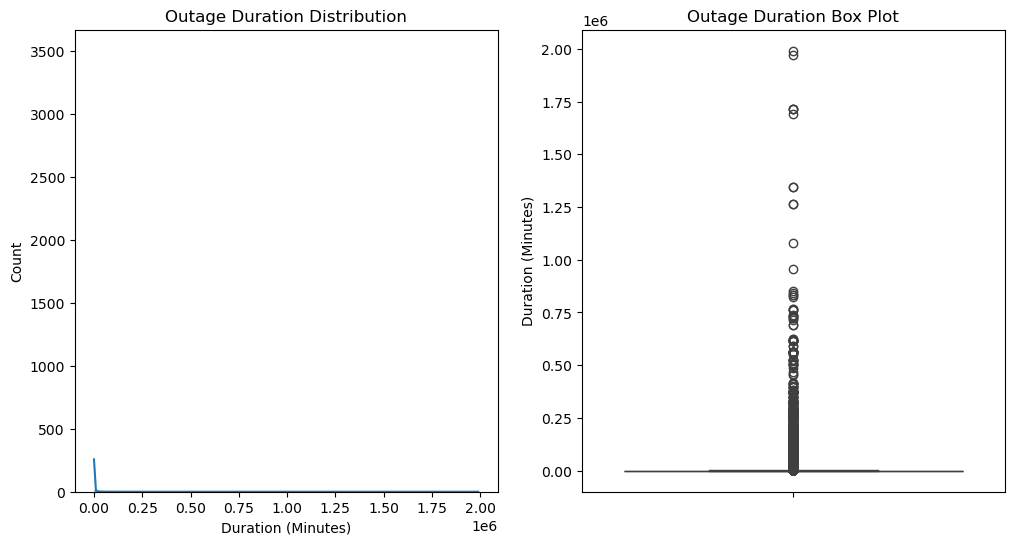


Outage Duration Quantiles:
0.10       81.0
0.25      179.0
0.50      380.0
0.75      661.0
0.90     4827.9
0.99    68074.0
Name: OUTAGE_DURATION_MINUTES, dtype: float64

2. Number of Outages:
Total Number of Outage Records: 100972
Number of Unique Outages: 40615

3. Categorical Variable Analysis:

Equipment Type Value Counts:
EQUIPMENTTYPE
LINE     54829
CB       35679
TRANS     9040
REAC       773
CAP        613
ISOL        23
UNIT        15
Name: count, dtype: int64

4. Numerical Discrete Variable Analysis:

Equipment Age Distribution:
EQ_AGE_AT_OUTAGE
0     5456
1     5192
2     3996
3     4358
4     4584
5     3981
6     5036
7     4365
8     5108
9     4837
10    4979
11    7791
12    7259
13    5855
14    5166
15    4862
16    3883
17    4019
18    3403
19    3506
20    3234
21      30
22      21
23      14
33       6
34       3
35       5
36       2
37       4
38       3
39       5
40       3
42       1
53       1
54       2
55       1
57       1
Name: count, dtype: int64


In [182]:
# --- Univariate Analysis ---
print("\n--- Univariate Analysis ---")

# 1. Outage Duration
print("\n1. Outage Duration Analysis:")
print(processed_df_final['OUTAGE_DURATION_MINUTES'].describe())  # Descriptive statistics

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(processed_df_final['OUTAGE_DURATION_MINUTES'], kde=True)
plt.title('Outage Duration Distribution')
plt.xlabel('Duration (Minutes)')

plt.subplot(1, 2, 2)
sns.boxplot(y=processed_df_final['OUTAGE_DURATION_MINUTES'])
plt.title('Outage Duration Box Plot')
plt.ylabel('Duration (Minutes)')
plt.show()

print("\nOutage Duration Quantiles:")
print(processed_df_final['OUTAGE_DURATION_MINUTES'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.99]))

# 2. Number of Outages
print("\n2. Number of Outages:")
print(f"Total Number of Outage Records: {len(processed_df_final)}")
print(f"Number of Unique Outages: {processed_df_final['OUTAGEID'].nunique()}")

# 3. Categorical Variables
print("\n3. Categorical Variable Analysis:")
print("\nEquipment Type Value Counts:")
print(processed_df_final['EQUIPMENTTYPE'].value_counts())

# 4. Numerical Discrete Variables
print("\n4. Numerical Discrete Variable Analysis:")
print("\nEquipment Age Distribution:")
print(processed_df_final['EQ_AGE_AT_OUTAGE'].value_counts().sort_index())




In [188]:
# 4. Numerical Discrete Variables
print("\n4. Numerical Discrete Variable Analysis:")
print("\nEquipment Age Distribution:")
print(processed_df_final['EQ_AGE_AT_OUTAGE'].value_counts().sort_index())


4. Numerical Discrete Variable Analysis:

Equipment Age Distribution:
EQ_AGE_AT_OUTAGE
0     5456
1     5192
2     3996
3     4358
4     4584
5     3981
6     5036
7     4365
8     5108
9     4837
10    4979
11    7791
12    7259
13    5855
14    5166
15    4862
16    3883
17    4019
18    3403
19    3506
20    3234
21      30
22      21
23      14
33       6
34       3
35       5
36       2
37       4
38       3
39       5
40       3
42       1
53       1
54       2
55       1
57       1
Name: count, dtype: int64


In [184]:
# --- NEW CODE: Outage Distribution by Season ---
print("\n5. Outage Distribution by Australian Season:")
print(processed_df_final['SEASON'].value_counts())



5. Outage Distribution by Australian Season:
SEASON
Winter    28173
Spring    27391
Autumn    26327
Summer    19081
Name: count, dtype: int64


In [129]:
print(processed_df_final_cleaned['EQ_AGE_AT_OUTAGE'].describe())

count    100972.000000
mean          9.700580
std           5.745595
min           0.000000
25%           5.000000
50%          10.000000
75%          14.000000
max          57.000000
Name: EQ_AGE_AT_OUTAGE, dtype: float64


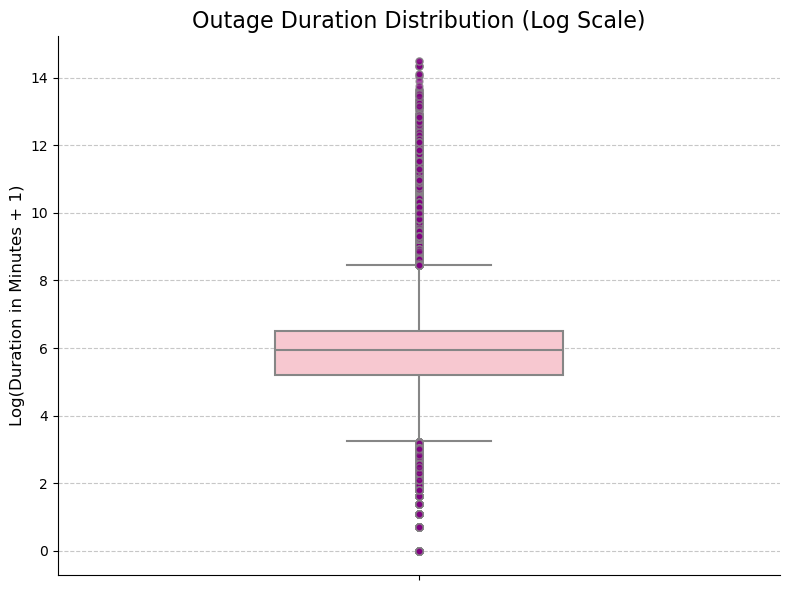

In [131]:
# Box Plot with Log Scale on Y-axis
plt.figure(figsize=(8, 6)) # Adjusted figure size for a single subplot

sns.boxplot(
    y=np.log1p(processed_df_final['OUTAGE_DURATION_MINUTES']),
    color='pink', # A pleasant, clean color
    width=0.4,       # Make the box a bit narrower for better aesthetics
    linewidth=1.5,   # Thicken the lines for better visibility
    fliersize=5,     # Adjust size of outlier points
    flierprops=dict(marker='o', markerfacecolor='purple', markersize=5, alpha=0.7) # Customize outlier appearance
)

plt.title('Outage Duration Distribution (Log Scale)', fontsize=16) # Clearer title
plt.ylabel('Log(Duration in Minutes + 1)', fontsize=12) # Clearer y-axis label
plt.xlabel('') # Remove x-axis label as it's a single box plot
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a subtle y-grid for easier reading of values
plt.tick_params(axis='y', labelsize=10) # Adjust tick label size

# Enhance spine visibility
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)


plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

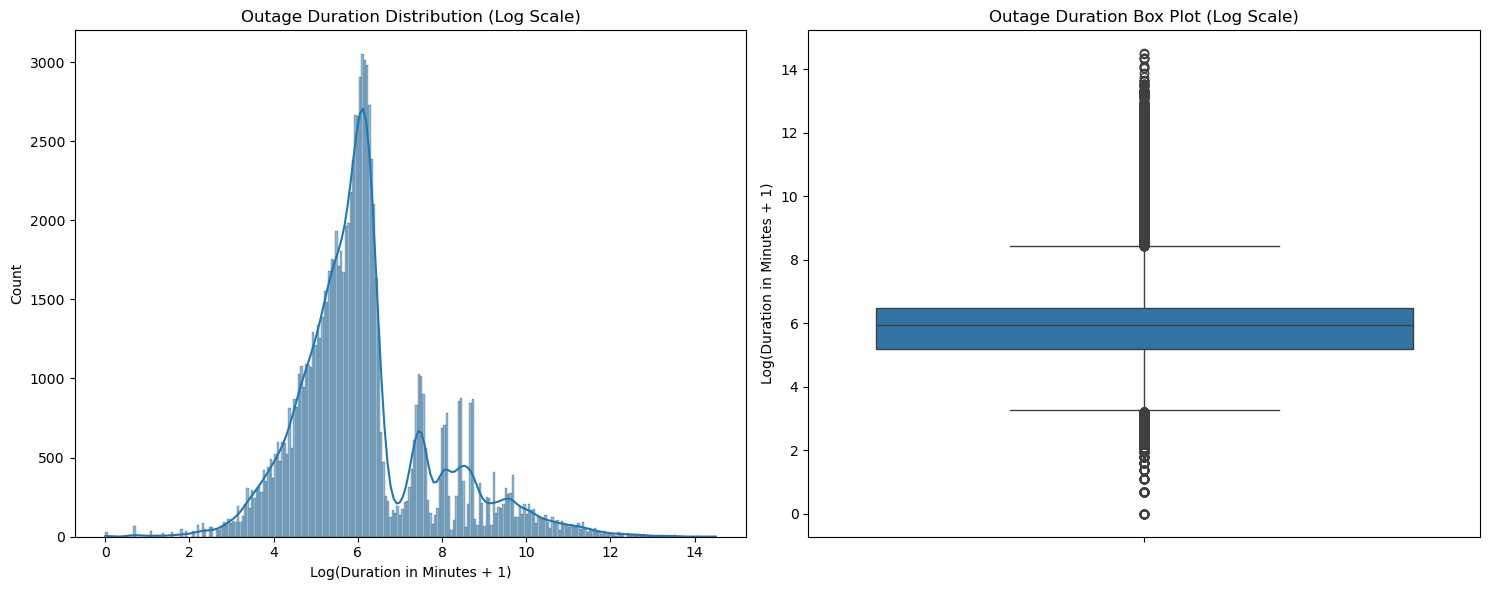

In [133]:
plt.figure(figsize=(15, 6))

# Histogram with Log Scale on X-axis
plt.subplot(1, 2, 1)
# Use np.log1p to handle potential zero values gracefully (log(0) is undefined)
sns.histplot(np.log1p(processed_df_final['OUTAGE_DURATION_MINUTES']), kde=True)
plt.title('Outage Duration Distribution (Log Scale)')
plt.xlabel('Log(Duration in Minutes + 1)')
plt.ylabel('Count')

# Box Plot with Log Scale on Y-axis
plt.subplot(1, 2, 2)
sns.boxplot(y=np.log1p(processed_df_final['OUTAGE_DURATION_MINUTES']))
plt.title('Outage Duration Box Plot (Log Scale)')
plt.ylabel('Log(Duration in Minutes + 1)')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [135]:
print("\n--- Descriptive Statistics for Outage Duration (Log Scale: log(x+1)) ---")
# Apply the log1p transformation and then get descriptive statistics
log_transformed_duration = np.log1p(processed_df_final['OUTAGE_DURATION_MINUTES'])
print(log_transformed_duration.describe())


--- Descriptive Statistics for Outage Duration (Log Scale: log(x+1)) ---
count    100972.000000
mean          6.147615
std           1.644084
min           0.000000
25%           5.192957
50%           5.942799
75%           6.495266
max          14.503985
Name: OUTAGE_DURATION_MINUTES, dtype: float64


In [137]:
# Calculate the log-transformed duration 
processed_df_final['LOG_OUTAGE_DURATION_MINUTES'] = np.log1p(processed_df_final['OUTAGE_DURATION_MINUTES'])

print("\n--- Categorizing Outage Duration ---")

# Method 1: Using Quantiles from the LOG-TRANSFORMED data to define cut points
# You provided: 25%=5.18, 50%=5.94, 75%=6.47 (on log scale)
# Let's use these values as the thresholds on the LOG_OUTAGE_DURATION_MINUTES column.

q1_log = 5.192957 # 25th percentile on log scale
q3_log = 6.495266 # 75th percentile on log scale

# Convert these log-scale thresholds back to original minutes for intuition/reporting
threshold_short_minutes = np.expm1(q1_log)
threshold_medium_minutes = np.expm1(q3_log)

print(f"Calculated thresholds for categorization (in original minutes):")
print(f"Short  : Duration <= {threshold_short_minutes:.2f} minutes")
print(f"Medium : {threshold_short_minutes:.2f} < Duration <= {threshold_medium_minutes:.2f} minutes")
print(f"Long   : Duration > {threshold_medium_minutes:.2f} minutes")

# Define the bins based on these thresholds in the LOG scale
# Use a very small number for the lower bound to include 0, and a very large for the upper bound.
bins = [processed_df_final['LOG_OUTAGE_DURATION_MINUTES'].min() - 0.01, q1_log, q3_log, processed_df_final['LOG_OUTAGE_DURATION_MINUTES'].max() + 0.01]
labels = ['Short', 'Medium', 'Long']

# Use pd.cut to categorize based on the log-transformed duration
processed_df_final['OUTAGE_CATEGORY_LOG_QUANTILE'] = pd.cut(
    processed_df_final['LOG_OUTAGE_DURATION_MINUTES'],
    bins=bins,
    labels=labels,
    right=True # Intervals are (a, b], so it includes the right endpoint
)

print("\nValue counts for new 'OUTAGE_CATEGORY_LOG_QUANTILE' column:")
print(processed_df_final['OUTAGE_CATEGORY_LOG_QUANTILE'].value_counts())


--- Categorizing Outage Duration ---
Calculated thresholds for categorization (in original minutes):
Short  : Duration <= 179.00 minutes
Medium : 179.00 < Duration <= 661.00 minutes
Long   : Duration > 661.00 minutes

Value counts for new 'OUTAGE_CATEGORY_LOG_QUANTILE' column:
OUTAGE_CATEGORY_LOG_QUANTILE
Medium    50455
Short     25317
Long      25200
Name: count, dtype: int64


In [169]:
processed_df_final['EQUIPMENT_AGE_BIN'] = pd.cut(
    processed_df_final['EQ_AGE_AT_OUTAGE'], bins=[0, 5, 10, 15, 20, 25, 30, 35, 40],
    labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40'], right=True
)

--- Raw Counts for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE  Short  Medium   Long
EQUIPMENTTYPE                                     
CAP                             153     287    173
CB                            10364   15506   9809
ISOL                              1       7     15
LINE                          12661   29936  12232
REAC                            198     304    271
TRANS                          1939    4407   2694
UNIT                              1       8      6

--- Percentages for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE     Short    Medium      Long
EQUIPMENTTYPE                                             
CAP                           0.249592  0.468189  0.282219
CB                            0.290479  0.434597  0.274924
ISOL                          0.043478  0.304348  0.652174
LINE                          0.230918  0.545988  0.223094
REAC                          0.256145  0.393273  0.350582
TRANS                         0.214491  0.48

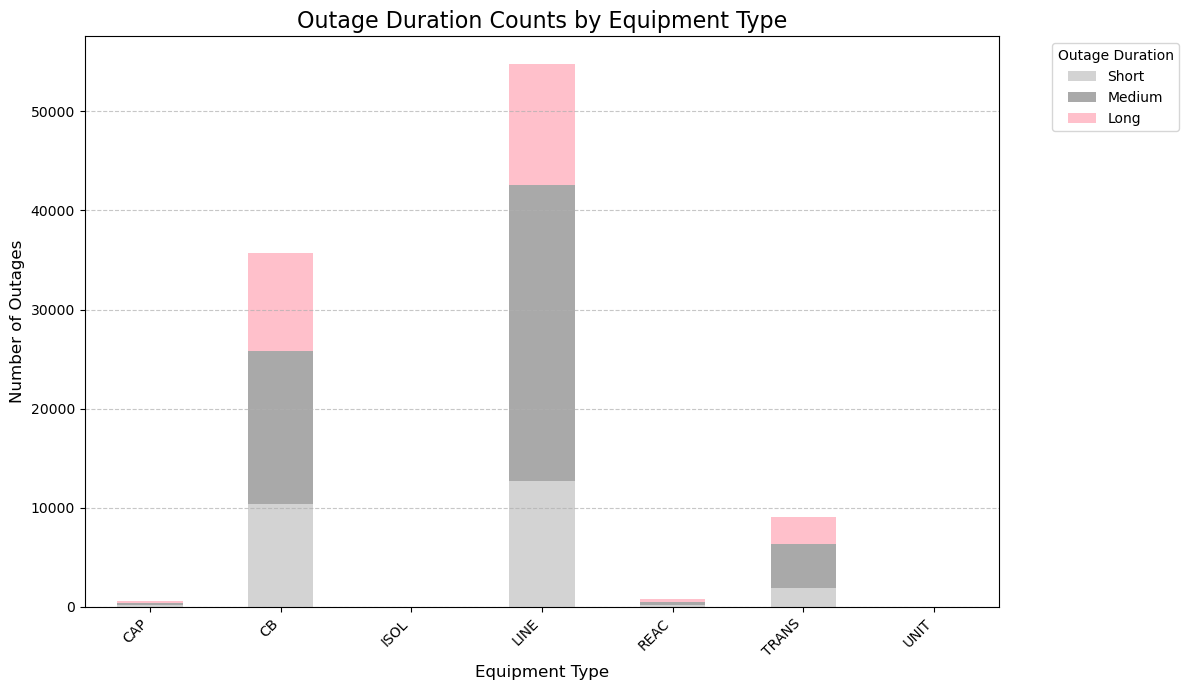

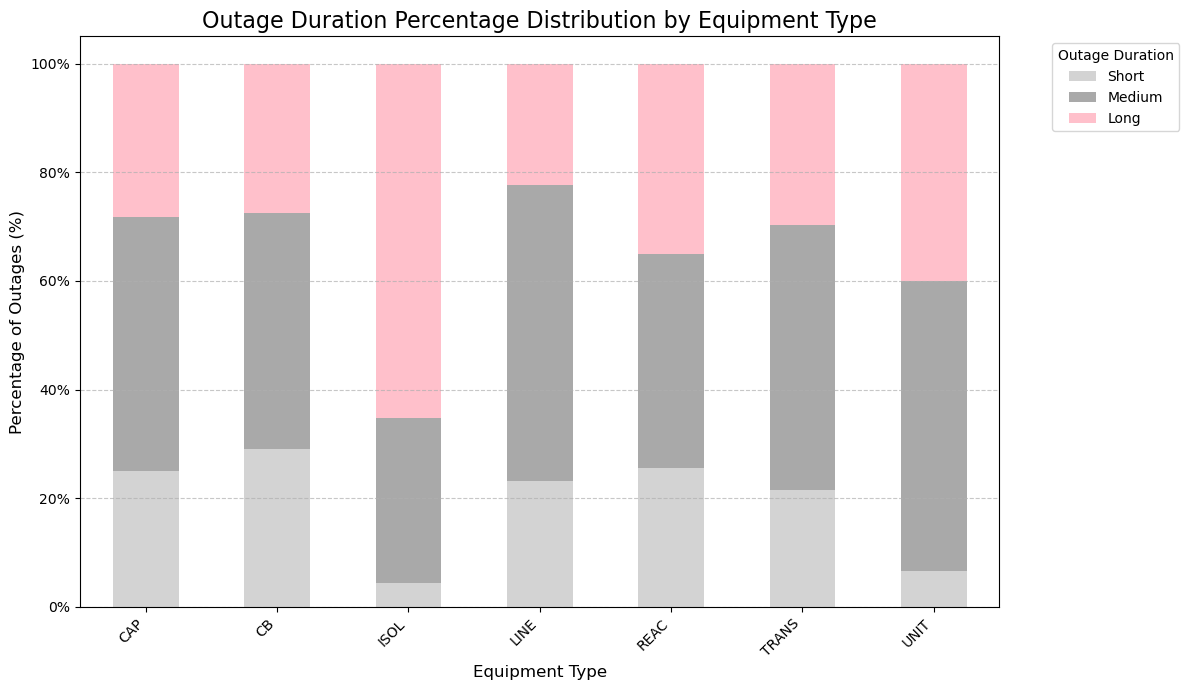

In [139]:
# --- 2. Define Custom Colors and Order ---
# Map the outage categories to your desired colors
# It's good practice to order them from "best" to "worst" or "shortest" to "longest"
# for consistent stacking and visual interpretation.
outage_colors = {
    'Short': 'lightgrey',
    'Medium': 'darkgrey',
    'Long': 'pink'
}
# Define the order of categories for consistent plotting (e.g., Short at bottom, Long at top)
outage_category_order = ['Short', 'Medium', 'Long']

# Get counts of each outage category per equipment type
# This creates a DataFrame where EQUIPMENTTYPE are rows and OUTAGE_CATEGORY_LOG_QUANTILE are columns
outage_counts = pd.crosstab(
    processed_df_final['EQUIPMENTTYPE'],
    processed_df_final['OUTAGE_CATEGORY_LOG_QUANTILE']
)

# Ensure columns are in the desired order for consistent stacking and color mapping
outage_counts = outage_counts[outage_category_order]

print("--- Raw Counts for Stacked Bar Chart ---")
print(outage_counts)

# Calculate percentages for the percentage-based stacked bar chart
outage_percentages = outage_counts.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Percentages for Stacked Bar Chart ---")
print(outage_percentages)


# --- CHART 1: Stacked Bar Chart (Counts) ---
plt.figure(figsize=(12, 7))
ax1 = outage_counts.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Counts by Equipment Type', fontsize=16)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Number of Outages', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- CHART 2: Stacked Bar Chart (Percentages) ---
plt.figure(figsize=(12, 7))
ax2 = outage_percentages.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Percentage Distribution by Equipment Type', fontsize=16)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Percentage of Outages (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

# Format y-axis to show percentages
from matplotlib.ticker import PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Raw Counts for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE  Short  Medium  Long
EQUIPMENT_AGE_BIN                                
0-5                            6062   11054  4995
6-10                           6614   12124  5587
11-15                          7472   15505  7956
16-20                          3925    8977  5143
21-25                            13      27    25
31-35                             6       6     2
36-40                             3       8     6

--- Percentages for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE     Short    Medium      Long
EQUIPMENT_AGE_BIN                                         
0-5                           0.274162  0.499932  0.225906
6-10                          0.271901  0.498417  0.229681
11-15                         0.241554  0.501245  0.257201
16-20                         0.217512  0.497479  0.285010
21-25                         0.200000  0.415385  0.384615
31-35                         0.428571  0.428571  0.1

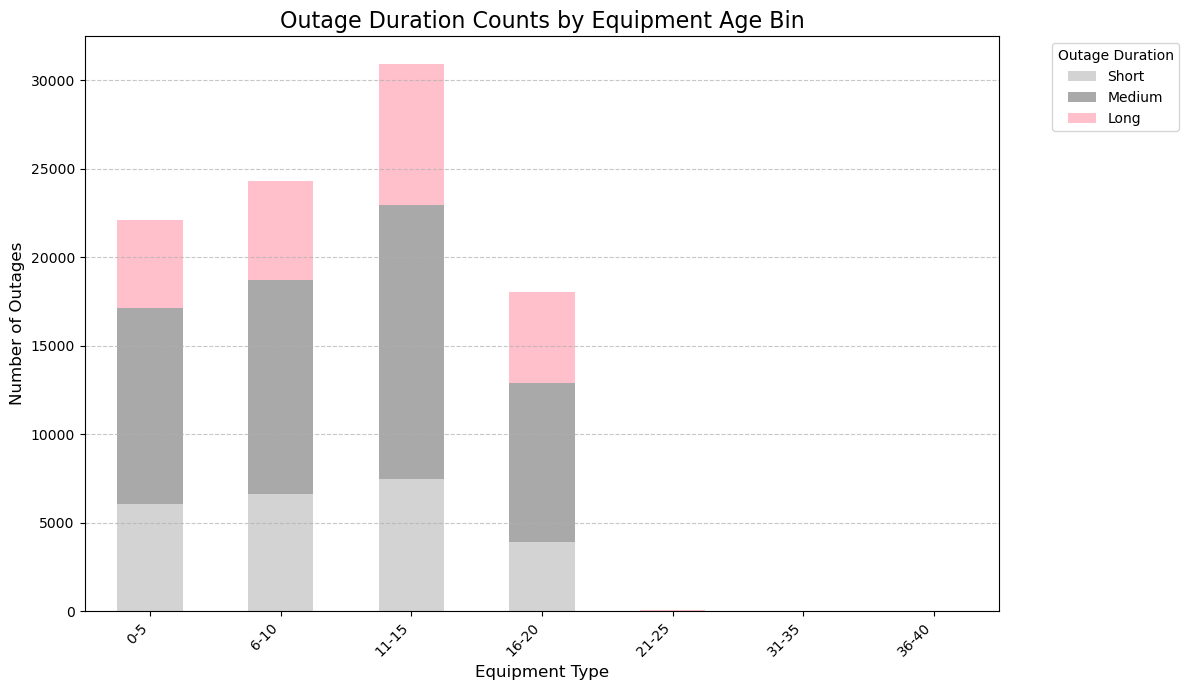

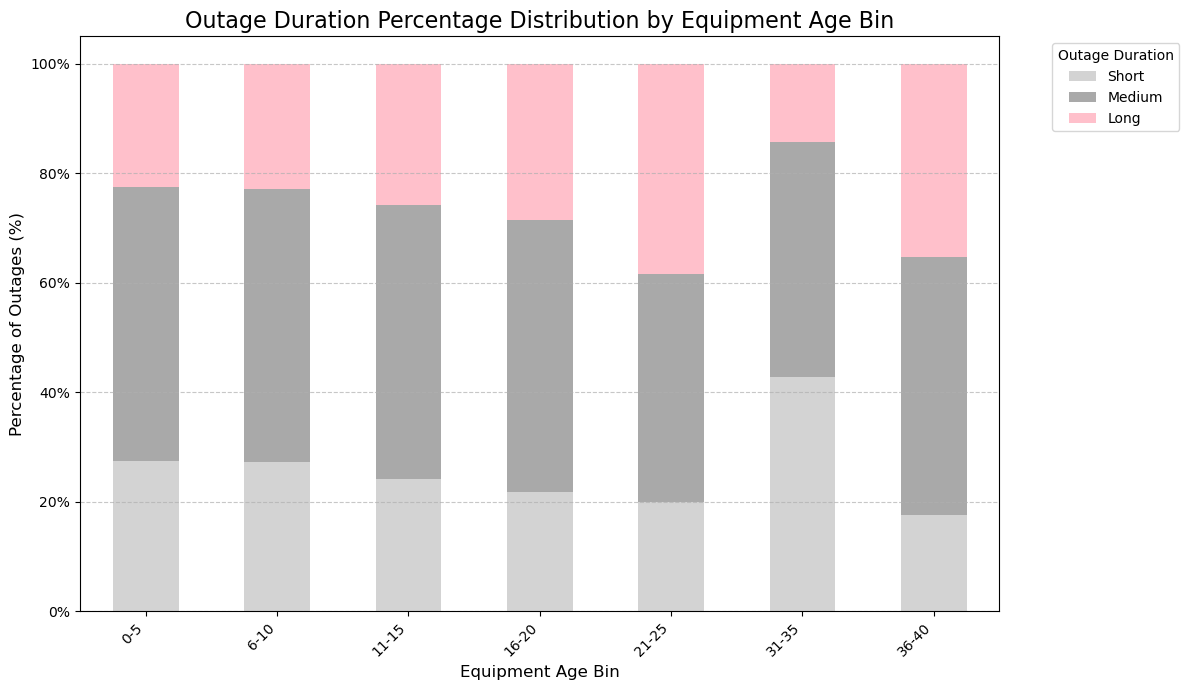

In [167]:
# --- 2. Define Custom Colors and Order ---
# Map the outage categories to your desired colors
# It's good practice to order them from "best" to "worst" or "shortest" to "longest"
# for consistent stacking and visual interpretation.
outage_colors = {
    'Short': 'lightgrey',
    'Medium': 'darkgrey',
    'Long': 'pink'
}
# Define the order of categories for consistent plotting (e.g., Short at bottom, Long at top)
outage_category_order = ['Short', 'Medium', 'Long']

# Get counts of each outage category per equipment type
# This creates a DataFrame where EQUIPMENTTYPE are rows and OUTAGE_CATEGORY_LOG_QUANTILE are columns
outage_counts = pd.crosstab(
    processed_df_final['EQUIPMENT_AGE_BIN'],
    processed_df_final['OUTAGE_CATEGORY_LOG_QUANTILE']
)

# Ensure columns are in the desired order for consistent stacking and color mapping
outage_counts = outage_counts[outage_category_order]

print("--- Raw Counts for Stacked Bar Chart ---")
print(outage_counts)

# Calculate percentages for the percentage-based stacked bar chart
outage_percentages = outage_counts.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Percentages for Stacked Bar Chart ---")
print(outage_percentages)


# --- CHART 1: Stacked Bar Chart (Counts) ---
plt.figure(figsize=(12, 7))
ax1 = outage_counts.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Counts by Equipment Age Bin', fontsize=16)
plt.xlabel('Equipment Type', fontsize=12)
plt.ylabel('Number of Outages', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- CHART 2: Stacked Bar Chart (Percentages) ---
plt.figure(figsize=(12, 7))
ax2 = outage_percentages.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Percentage Distribution by Equipment Age Bin', fontsize=16)
plt.xlabel('Equipment Age Bin', fontsize=12)
plt.ylabel('Percentage of Outages (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

# Format y-axis to show percentages
from matplotlib.ticker import PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Raw Counts for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE  Short  Medium  Long
SEASON                                           
Autumn                         6408   13278  6641
Spring                         6950   12943  7498
Summer                         5227   10118  3736
Winter                         6732   14116  7325

--- Percentages for Stacked Bar Chart ---
OUTAGE_CATEGORY_LOG_QUANTILE     Short    Medium      Long
SEASON                                                    
Autumn                        0.243400  0.504349  0.252251
Spring                        0.253733  0.472527  0.273740
Summer                        0.273937  0.530266  0.195797
Winter                        0.238952  0.501047  0.260001


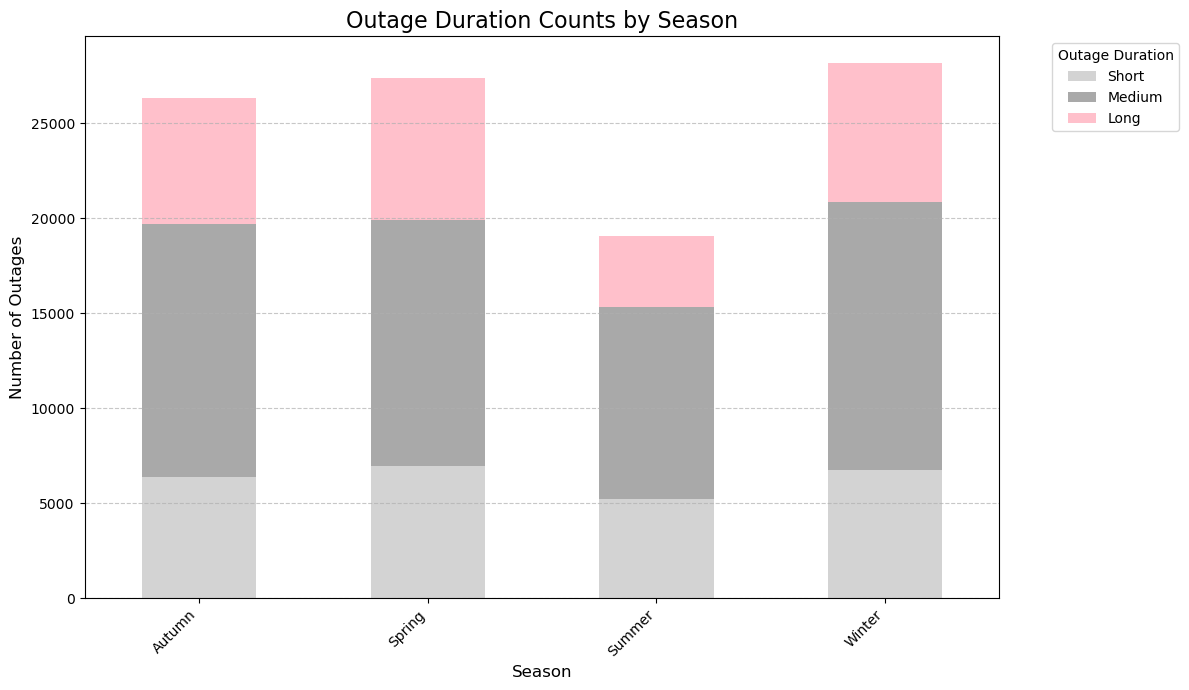

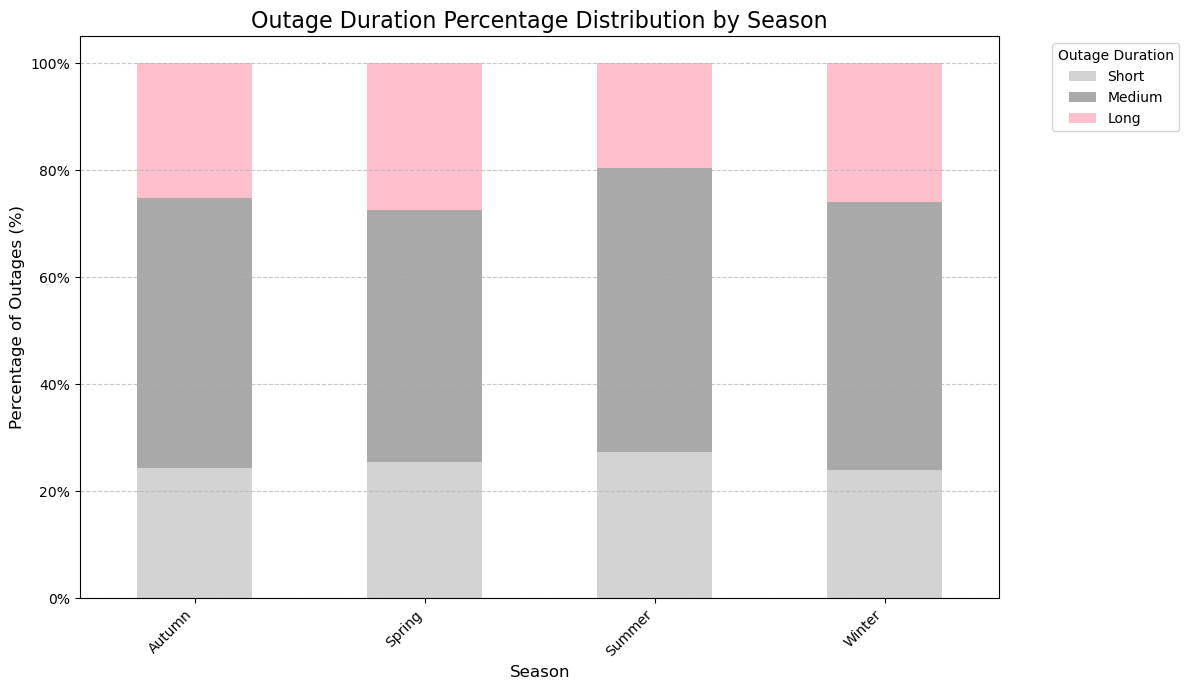

In [171]:
# --- 2. Define Custom Colors and Order ---
# Map the outage categories to your desired colors
# It's good practice to order them from "best" to "worst" or "shortest" to "longest"
# for consistent stacking and visual interpretation.
outage_colors = {
    'Short': 'lightgrey',
    'Medium': 'darkgrey',
    'Long': 'pink'
}
# Define the order of categories for consistent plotting (e.g., Short at bottom, Long at top)
outage_category_order = ['Short', 'Medium', 'Long']

# Get counts of each outage category per equipment type
# This creates a DataFrame where EQUIPMENTTYPE are rows and OUTAGE_CATEGORY_LOG_QUANTILE are columns
outage_counts = pd.crosstab(
    processed_df_final['SEASON'],
    processed_df_final['OUTAGE_CATEGORY_LOG_QUANTILE']
)

# Ensure columns are in the desired order for consistent stacking and color mapping
outage_counts = outage_counts[outage_category_order]

print("--- Raw Counts for Stacked Bar Chart ---")
print(outage_counts)

# Calculate percentages for the percentage-based stacked bar chart
outage_percentages = outage_counts.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Percentages for Stacked Bar Chart ---")
print(outage_percentages)


# --- CHART 1: Stacked Bar Chart (Counts) ---
plt.figure(figsize=(12, 7))
ax1 = outage_counts.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Counts by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Number of Outages', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- CHART 2: Stacked Bar Chart (Percentages) ---
plt.figure(figsize=(12, 7))
ax2 = outage_percentages.plot(
    kind='bar',
    stacked=True,
    color=[outage_colors[cat] for cat in outage_category_order],
    ax=plt.gca() # Use current axes
)

plt.title('Outage Duration Percentage Distribution by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Percentage of Outages (%)', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

# Format y-axis to show percentages
from matplotlib.ticker import PercentFormatter
ax2.yaxis.set_major_formatter(PercentFormatter(1.0))

plt.legend(title='Outage Duration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [147]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

# ARM

In [149]:
processed_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100972 entries, 0 to 100971
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   OUTAGEID                      100972 non-null  float64 
 1   SUBSTATIONID                  100972 non-null  object  
 2   EQUIPMENTTYPE                 100972 non-null  object  
 3   EQUIPMENTID                   100972 non-null  object  
 4   REASON                        100972 non-null  object  
 5   ISSECONDARY                   100972 non-null  float64 
 6   ACTUAL_STARTTIME              100972 non-null  object  
 7   ACTUAL_ENDTIME                100972 non-null  object  
 8   OUTAGE_DURATION_MINUTES       100972 non-null  float64 
 9   SUBSTATION_SUBURB             100972 non-null  object  
 10  EQ_AGE_AT_OUTAGE              100972 non-null  int64   
 11  SEASON                        100972 non-null  object  
 12  LOG_OUTAGE_DURATION_MINUTES   

In [151]:
# Make sure all columns are object/category Dtype where appropriate for ARM
for col in ['EQUIPMENTTYPE', 'REASON', 'SEASON','OUTAGE_CATEGORY_LOG_QUANTILE',
            'EQUIPMENT_AGE_BIN', 'ISSECONDARY']:
    processed_df_final[col] = processed_df_final[col].astype('category')

# --- START OF ARM CODE ---
print("--- Association Rule Mining using FP-Growth ---")

# 1. Select Relevant Categorical Columns for ARM
# Choose features that are already categorical or have been appropriately binned.
# Avoid columns with very high cardinality (too many unique values) like OUTAGEID, EQUIPMENTID, SUBSTATIONID,
# COMPANYREFCODE, DESCRIPTION, SUBSTATION_SUBURB, as they make itemsets too sparse.
# 'VOLTAGE' and 'SUBSTATION_VOLTAGE' can have NaNs; they will become 'nan' string if not handled.

arm_features = [
    'EQUIPMENTTYPE',
    'SEASON',
    'REASON',
    'EQUIPMENT_AGE_BIN',
    'ISSECONDARY',
    'OUTAGE_CATEGORY_LOG_QUANTILE' # This is our target for the consequent (RHS)
]

# Create a subset DataFrame for ARM
arm_df = processed_df_final[arm_features].copy()

# 2. Handle Missing Values in ARM Features
# For ARM, rows with NaN in selected features are typically dropped or NaNs are treated as a distinct category.
# Dropping is simpler and common if missingness isn't a core part of the rule itself.
initial_arm_rows = len(arm_df)
arm_df.dropna(inplace=True) # Drops rows with any NaN in the selected ARM features
rows_dropped_for_arm = initial_arm_rows - len(arm_df)
print(f"Dropped {rows_dropped_for_arm} rows from ARM dataset due to missing values in selected features.")


--- Association Rule Mining using FP-Growth ---
Dropped 5462 rows from ARM dataset due to missing values in selected features.


In [153]:
# 3. Convert Data to Transaction Format (One-Hot Encoding)
# Each row in arm_df is a transaction. Each unique value becomes an item.
# Crucially, prefix item names to avoid ambiguity (e.g., 'Long' from duration vs 'Long' from age if it existed).
# pd.get_dummies automatically handles prefixing if you provide `prefix=col_name` or `prefix_sep='_'`

# Convert all columns to string type for get_dummies to treat them as distinct items
# This is crucial for categorical/object types and for NaNs that became 'nan' string.
for col in arm_df.columns:
    arm_df[col] = arm_df[col].astype(str)

transactions_df3 = pd.get_dummies(arm_df, prefix_sep='_', prefix=arm_df.columns.tolist())

print(f"\nShape of one-hot encoded transaction DataFrame: {transactions_df3.shape}")
print(f"Sample of one-hot encoded transactions (first 5 rows, first 10 columns):")
print(transactions_df3.iloc[:5, :10]) # Displaying first 10 columns for brevity



Shape of one-hot encoded transaction DataFrame: (95510, 28)
Sample of one-hot encoded transactions (first 5 rows, first 10 columns):
      EQUIPMENTTYPE_CAP  EQUIPMENTTYPE_CB  EQUIPMENTTYPE_ISOL  \
2209              False             False               False   
2210              False              True               False   
2211              False              True               False   
2212              False              True               False   
2237              False             False               False   

      EQUIPMENTTYPE_LINE  EQUIPMENTTYPE_REAC  EQUIPMENTTYPE_TRANS  \
2209                True               False                False   
2210               False               False                False   
2211               False               False                False   
2212               False               False                False   
2237                True               False                False   

      EQUIPMENTTYPE_UNIT  SEASON_Autumn  SEASON_Spring  SEAS

In [155]:
# 4. Generate Frequent Itemsets using FP-Growth
# min_support: Adjust based on dataset size and how common you expect rules to be.
# A lower value yields more itemsets but increases computational cost.
min_support_threshold = 0.005 # Example: 0.5% support (can be adjusted)

print(f"\nGenerating frequent itemsets with min_support={min_support_threshold}...")
frequent_itemsets = fpgrowth(transactions_df3, min_support=min_support_threshold, use_colnames=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets.")
print("Sample of Frequent Itemsets (sorted by support, top 10):")
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

# 5. Generate Association Rules
# Metric: 'lift' is usually best for discovery.
# min_threshold: For lift, values > 1 indicate a positive association.
min_lift_threshold = 1.2 # Example: Consequent is at least 20% more likely given the antecedent

print(f"\nGenerating association rules with metric='lift' and min_threshold={min_lift_threshold}...")
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift_threshold)

print(f"Found {len(rules)} association rules.")
print("Sample of all generated rules (sorted by lift, top 5):")
print(rules.sort_values(by='lift', ascending=False).head())



Generating frequent itemsets with min_support=0.005...
Found 1885 frequent itemsets.
Sample of Frequent Itemsets (sorted by support, top 10):
      support                                           itemsets
0    0.726814                                  (ISSECONDARY_0.0)
1    0.631777                     (REASON_HV equipt maintenance)
22   0.620228    (ISSECONDARY_0.0, REASON_HV equipt maintenance)
2    0.536153                               (EQUIPMENTTYPE_LINE)
9    0.499435              (OUTAGE_CATEGORY_LOG_QUANTILE_Medium)
6    0.359198                                 (EQUIPMENTTYPE_CB)
829  0.343283  (ISSECONDARY_0.0, OUTAGE_CATEGORY_LOG_QUANTILE...
581  0.329683                (ISSECONDARY_0.0, EQUIPMENTTYPE_CB)
20   0.323872                          (EQUIPMENT_AGE_BIN_11-15)
827  0.314177  (REASON_HV equipt maintenance, OUTAGE_CATEGORY...

Generating association rules with metric='lift' and min_threshold=1.2...
Found 13404 association rules.
Sample of all generated rules (sorted

In [157]:
# 6. Filter Rules for 'Long' Outages (as Consequent)
target_consequent = "OUTAGE_CATEGORY_LOG_QUANTILE_Long"

print(f"\n--- Filtering Rules where Consequent is ONLY '{target_consequent}' (RHS) ---")
# Modified filtering:
# Ensure the consequent frozenset has exactly one item, AND that item is the target_consequent.
long_outage_rules_4 = rules[
    rules['consequents'].apply(lambda x: len(x) == 1 and target_consequent in x)
].copy()

if not long_outage_rules_4.empty:
    print(f"Found {len(long_outage_rules_4)} rules where the consequent is ONLY '{target_consequent}'.")
    print("\nTop rules with 'Long' Outages as the ONLY consequent (sorted by Lift then Confidence):")
    print(long_outage_rules_4.sort_values(by=['lift', 'confidence','support'], ascending=[False, False, False]))

    # --- NEW CODE: Filter for One-to-One Rules to Long Duration ---
    # This block now implicitly works with long_outage_rules_3 where
    # the consequent is already guaranteed to be only 'Long'.
    print("\n--- One-to-One Rules to 'Long' Outage Duration (Consequent is ONLY 'Long') ---")

    # Filter rules where:
    # 1. The antecedent contains exactly one item
    # (The consequent is already guaranteed to be exactly one item and 'Long' due to the previous filter)
    one_to_one_rules = long_outage_rules_4[
        long_outage_rules_4['antecedents'].apply(lambda x: len(x) == 1)
    ].copy()

    if not one_to_one_rules.empty:
        print(f"Found {len(one_to_one_rules)} one-to-one rules to 'Long' Outage Duration.")
        print("Sorted by Lift (descending):")
        print(one_to_one_rules.sort_values(by='lift', ascending=False))
        # Sort by lift in descending order before saving
        one_to_one_rules_sorted = one_to_one_rules.sort_values(by=['lift', 'confidence','support'], ascending=[False, False,False]).copy()

        # Optional: Save these specific rules to a separate CSV
        output_folder = 'data'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        csv_filename_one_to_one = 'one_to_one_long_outage_rules2.csv'
        output_path_one_to_one = os.path.join(output_folder, csv_filename_one_to_one)
        one_to_one_rules_sorted.to_csv(output_path_one_to_one, index=False)
        print(f"\nSuccessfully saved {len(one_to_one_rules_sorted)} one-to-one rules to: {output_path_one_to_one}")

    else:
        print("No one-to-one rules found to 'Long' Outage Duration with current filters.")


    # --- Your existing code to save all long_outage_rules_3 to CSV ---
    long_outage_rules_4_sorted = long_outage_rules_4.sort_values(by=['lift', 'confidence', 'support'], ascending=[False, False,False]).copy()
    output_folder = 'data' # Assuming you want to save it in the 'data' folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder) # Create the folder if it doesn't exist

    csv_filename = 'long_outage_association_rules_4.csv'
    output_path = os.path.join(output_folder, csv_filename)

    long_outage_rules_4_sorted.to_csv(output_path, index=False)
    print(f"\nSuccessfully saved {len(long_outage_rules_4_sorted)} rules to: {output_path}")

else:
    print(f"No rules found with '{target_consequent}' as the ONLY consequent based on current thresholds.")
    print("Consider lowering min_support or min_lift_threshold to find more rules.")

print("\n--- End of Association Rule Mining ---")


--- Filtering Rules where Consequent is ONLY 'OUTAGE_CATEGORY_LOG_QUANTILE_Long' (RHS) ---
Found 121 rules where the consequent is ONLY 'OUTAGE_CATEGORY_LOG_QUANTILE_Long'.

Top rules with 'Long' Outages as the ONLY consequent (sorted by Lift then Confidence):
                                             antecedents  \
9823   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9809   (REASON_HV equipt commissioning, EQUIPMENT_AGE...   
10082  (REASON_HV equipt commissioning, SEASON_Spring...   
10098  (SEASON_Spring, REASON_HV equipt commissioning...   
9449   (REASON_HV equipt commissioning, EQUIPMENTTYPE...   
...                                                  ...   
1522   (ISSECONDARY_0.0, EQUIPMENTTYPE_LINE, EQUIPMEN...   
7957   (EQUIPMENTTYPE_TRANS, REASON_HV equipt mainten...   
7194   (EQUIPMENT_AGE_BIN_11-15, ISSECONDARY_0.0, SEA...   
7186   (EQUIPMENT_AGE_BIN_11-15, SEASON_Spring, REASO...   
7560          (EQUIPMENT_AGE_BIN_11-15, ISSECONDARY_0.0)   

                 

In [159]:
# Filter the DataFrame
filtered_rules2 = long_outage_rules_4_sorted[
    (long_outage_rules_4_sorted['lift'] > 1.2) &
    (long_outage_rules_4_sorted['confidence'] > 0.60) # Confidence is a proportion, so 50% is 0.50
].copy()

print(filtered_rules2)

                                             antecedents  \
9823   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9809   (REASON_HV equipt commissioning, EQUIPMENT_AGE...   
10082  (REASON_HV equipt commissioning, SEASON_Spring...   
10098  (SEASON_Spring, REASON_HV equipt commissioning...   
9449   (REASON_HV equipt commissioning, EQUIPMENTTYPE...   
9463   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9232   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9216   (REASON_HV equipt commissioning, SEASON_Winter...   
10140  (REASON_HV equipt commissioning, EQUIPMENT_AGE...   
10156  (REASON_HV equipt commissioning, ISSECONDARY_0...   

                               consequents  antecedent support  \
9823   (OUTAGE_CATEGORY_LOG_QUANTILE_Long)            0.009297   
9809   (OUTAGE_CATEGORY_LOG_QUANTILE_Long)            0.009350   
10082  (OUTAGE_CATEGORY_LOG_QUANTILE_Long)            0.009151   
10098  (OUTAGE_CATEGORY_LOG_QUANTILE_Long)            0.009151   
9449   (O

In [161]:

output_folder = 'data' # Assuming you want to save it in the 'data' folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder) # Create the folder if it doesn't exist

csv_filename = 'long_outage_association_rules_filtered.csv'
output_path = os.path.join(output_folder, csv_filename)

filtered_rules2.to_csv(output_path, index=False)
print(f"\nSuccessfully saved {len(filtered_rules2)} rules to: {output_path}")


Successfully saved 10 rules to: data\long_outage_association_rules_filtered.csv


In [163]:
# --- Plotting Parameters ---
num_rules_to_plot = 10
min_plot_confidence_line = 0.5
min_plot_support_line = 0.005

# --- Function to Generate Scatter Plots ---
def plot_top_rules2(rules_df, title_prefix):
    """
    Generates a scatter plot for the top N association rules based on the provided DataFrame.

    Args:
        rules_df (pd.DataFrame): DataFrame containing association rules, expected to be
                                 already sorted by lift, confidence, then support.
        title_prefix (str): A string to prefix the plot title, e.g., "One-to-One Rules".
    """
    top_rules_for_plot = rules_df.head(num_rules_to_plot).copy()
    print(f"\n--- Plotting Top {num_rules_to_plot} Rules for {title_prefix} ---")
    print("Rules selected for plot (sorted by lift, confidence, then support):")
    print(rules_df[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x="support",
        y="confidence",
        size="lift",      # Size of points indicates lift
        hue="lift",       # Color of points indicates lift
        data=rules_df,
        palette="viridis", # Choose a color palette
        sizes=(100, 1000), # Adjust min/max size of points for better visibility
        legend='full'
    )
    plt.title(f"Top Association Rules for {title_prefix}: Support vs. Confidence (Colored/Sized by Lift)")
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add dotted lines for visual guidance
    plt.axhline(min_plot_confidence_line, color='red', linestyle=':', label=f'Confidence Line ({min_plot_confidence_line})')
    plt.axvline(min_plot_support_line, color='green', linestyle=':', label=f'Support Line ({min_plot_support_line})')

    plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0)) # Adjust legend position
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


--- Debugging: Number of rules in DataFrame passed to plotter: 10 ---

--- Plotting Top 10 Rules for Long Outage Rules Lift 1.2 and Confidence 60% ---
Rules selected for plot (sorted by lift, confidence, then support):
                                             antecedents  \
9823   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9809   (REASON_HV equipt commissioning, EQUIPMENT_AGE...   
10082  (REASON_HV equipt commissioning, SEASON_Spring...   
10098  (SEASON_Spring, REASON_HV equipt commissioning...   
9449   (REASON_HV equipt commissioning, EQUIPMENTTYPE...   
9463   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9232   (REASON_HV equipt commissioning, ISSECONDARY_0...   
9216   (REASON_HV equipt commissioning, SEASON_Winter...   
10140  (REASON_HV equipt commissioning, EQUIPMENT_AGE...   
10156  (REASON_HV equipt commissioning, ISSECONDARY_0...   

                               consequents   support  confidence      lift  
9823   (OUTAGE_CATEGORY_LOG_QUANTILE_Long)

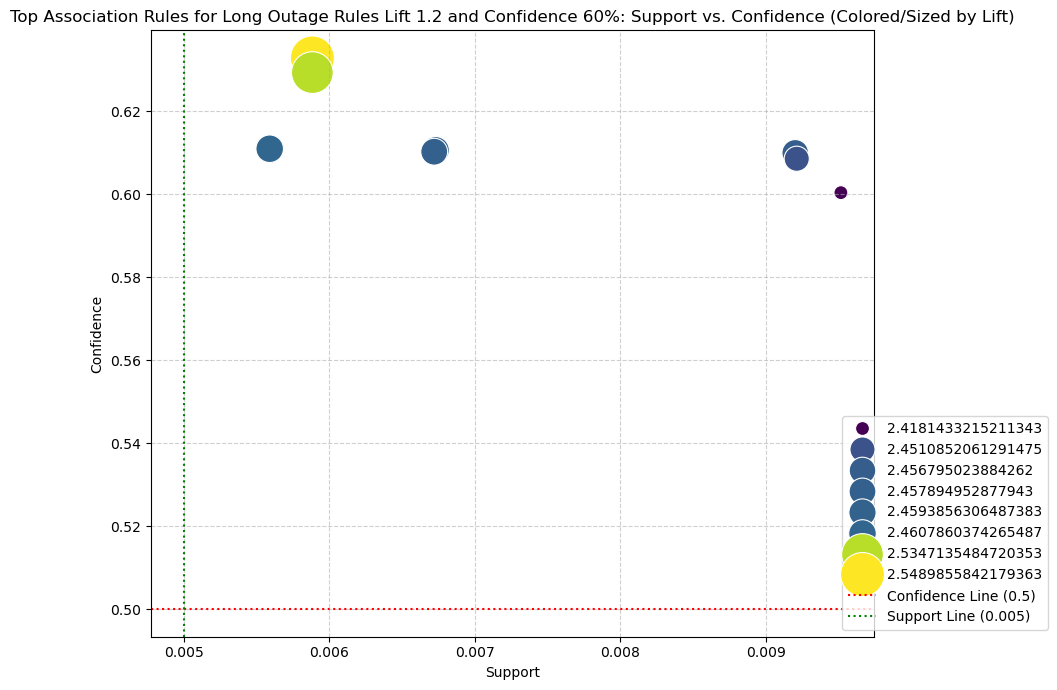

In [165]:
# Plot for long_outage_rules_3_sorted
# Add this before calling plot_top_rules2
print(f"\n--- Debugging: Number of rules in DataFrame passed to plotter: {len(filtered_rules2)} ---")

plot_top_rules2(filtered_rules2, "Long Outage Rules Lift 1.2 and Confidence 60%")